In [1]:
# CELL 1 — Imports, config, reproducibility, device, paths
import os, random, json, math, time, shutil, csv
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils
import timm
from torchviz import make_dot
import torch

# Grad-CAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
import cv2

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

# SWA
from torch.optim.swa_utils import AveragedModel, update_bn

# sklearn metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    accuracy_score, roc_auc_score, r2_score)
from torchvision.transforms import RandAugment

# place near imports
def hflip_pil(img):
    return img.transpose(Image.FLIP_LEFT_RIGHT)

def rot90_pil(img):
    return img.rotate(90, expand=True)

def get_tta_transform(t):
    if t == "orig":
        return val_tfms

    if t == "hflip":
        return transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.Lambda(hflip_pil),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

    if t == "rot90":
        return transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.Lambda(rot90_pil),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

    return val_tfms


# -----------------------------
# CONFIG - tweak as needed
# -----------------------------
config = {
    # dataset (update to your folder)
    "data_root": r"E:\Python\ADL project\Lung Disease Dataset",

    # model choices (timm names) - updated per request
    "model_choices": ["densenet121", "efficientnet_b0", "resnet50"],

    # training regime
    "epochs_frozen": 10,
    "epochs_finetune": 10,
    "lr_frozen": 1e-4,
    "lr_finetune": 5e-5,

    # optimizer
    "optimizer": "auto",      # auto/adam/adamw/radam/sgd/ranger
    "weight_decay": 1e-4,

    # regularization + data
    "dropout_rate": 0.4,
    "batch_size": 16,
    "num_workers": 2,

    # gradual unfreeze
    "gradual_unfreeze_k": 2,

    # scheduler
    "use_plateau": False,
    "warmup_epochs": 2,

    # AMP & deterministic
    "use_amp": True,
    "deterministic": False,

    # early stopping
    "early_stop_patience": 5,
    "early_stop_metric": "auto",    # 'auto' | 'val_acc' | 'val_loss'
    "early_stop_target_acc": None,

    # MixUp/CutMix
    "mixup": False,
    "mixup_alpha": 0.3,
    "cutmix": False,
    "cutmix_alpha": 1.0,

    # advanced augmentations
    "use_albumentations": False,

    # TTA & SWA: SWA enabled
    "tta": True,
    "tta_transforms": ["orig", "hflip"],
    "use_swa": False,
    "swa_start": 6,      # start SWA after this many fine-tune epochs
    "swa_lr": 1e-5,
    "swa_anneal_epochs": 3,

    # logging / outputs
    "use_tensorboard": True,
    "use_wandb": False,
    "results_dir": "results",

    # reproducibility
    "seed": 42,

    # keep Grad-CAM IoU and resume disabled (per request)
    "cam_mask_dir": None,
    "resume_ckpt": None
}

# -----------------------------
# Repro + device
# -----------------------------
SEED = config["seed"]
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

try:
    if config["deterministic"]:
        torch.use_deterministic_algorithms(True)
        torch.backends.cudnn.benchmark = False
except Exception:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}; PyTorch: {torch.__version__}; CUDA available: {torch.cuda.is_available()}")

# -----------------------------
# Paths
# -----------------------------
DATA_ROOT = Path(config["data_root"])
TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR   = DATA_ROOT / "val"
TEST_DIR  = DATA_ROOT / "test"

# cleanup possible .ipynb_checkpoints
for split in ['train', 'val', 'test']:
    ckpt_path = DATA_ROOT / split / '.ipynb_checkpoints'
    if ckpt_path.exists(): shutil.rmtree(ckpt_path, ignore_errors=True)

# ensure dataset exists
assert TRAIN_DIR.exists(), f"Train dir not found: {TRAIN_DIR}"
assert VAL_DIR.exists(), f"Val dir not found: {VAL_DIR}"
assert TEST_DIR.exists(), f"Test dir not found: {TEST_DIR}"

RESULTS_DIR = Path(config["results_dir"]); RESULTS_DIR.mkdir(exist_ok=True)
LOG_DIR = RESULTS_DIR / "logs"; LOG_DIR.mkdir(exist_ok=True)

# optional tensorboard
writer = SummaryWriter(LOG_DIR) if config["use_tensorboard"] else None


Device: cuda; PyTorch: 2.7.1+cu118; CUDA available: True


Classes: ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
Sizes: train 6054 val 2016 test 2027


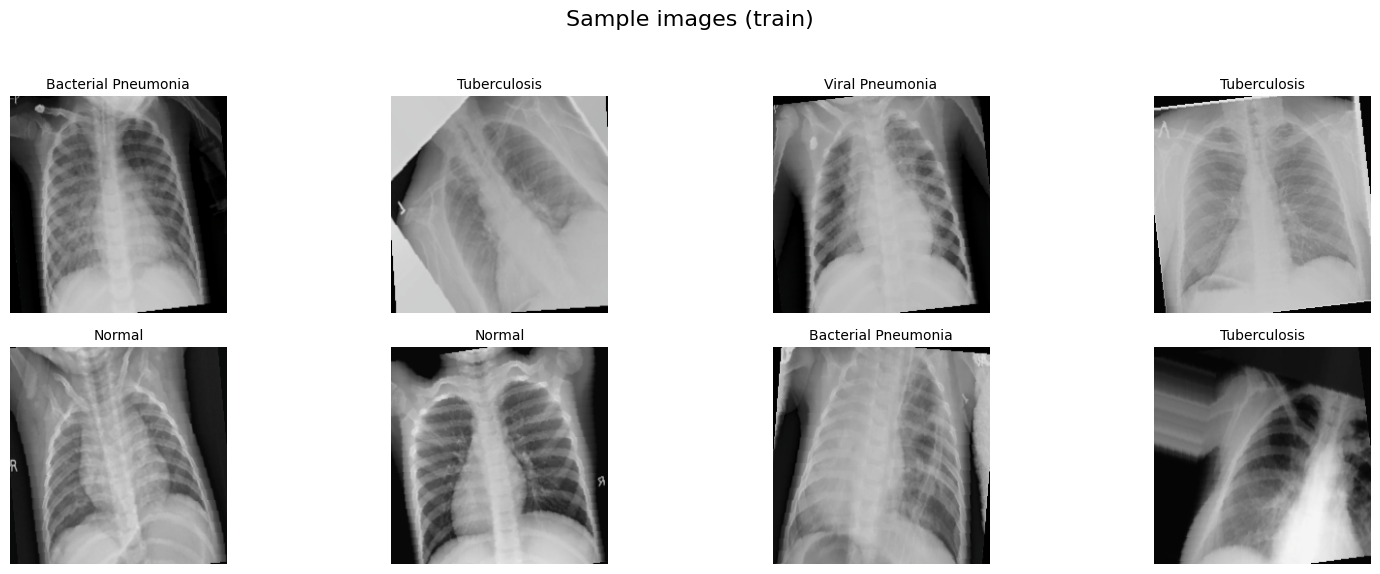

,class,count
0,Tuberculosis,1220
1,Corona Virus Disease,1218
2,Normal,1207
3,Bacterial Pneumonia,1205
4,Viral Pneumonia,1204


,model,params
0,densenet121,7.98M
1,efficientnet_b0,5.29M
2,resnet50,25.56M


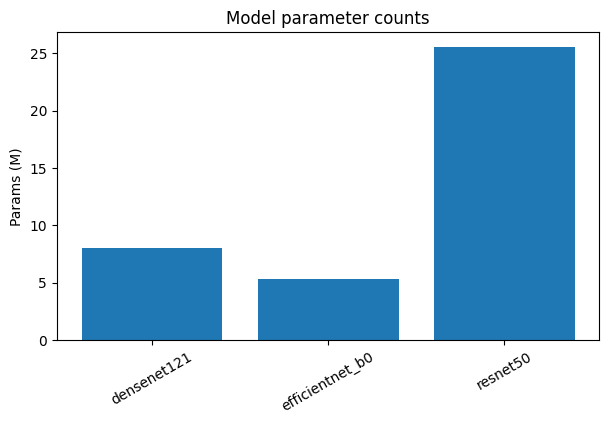

In [2]:
# CELL 2 — Dataloaders, sample images, dataset summary, model summary table & plot
IMG_SIZE = 224
BATCH_SIZE = config["batch_size"]
NUM_WORKERS = config["num_workers"]

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.9,1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=val_tfms)
test_ds  = datasets.ImageFolder(TEST_DIR, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)
print("Sizes: train", len(train_ds), "val", len(val_ds), "test", len(test_ds))

# Show a grid of sample images (8) with labels
def show_sample_grid(dataset, n=8, seed=SEED):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(dataset), size=min(n, len(dataset)), replace=False)
    imgs = []
    labels = []
    for i in idxs:
        img, lab = dataset[i]
        # img is a tensor normalized; convert back to displayable numpy image
        np_img = img.numpy().transpose(1,2,0)
        np_img = (np_img * std) + mean
        np_img = np.clip(np_img, 0, 1)
        imgs.append(np_img)
        labels.append(dataset.classes[lab])

    # Create subplots (rows x cols) — keep 4 columns like before
    cols = 4
    rows = int(np.ceil(len(imgs) / cols))
    plt.figure(figsize=(4*cols, 3*rows))
    for i, (im, lbl) in enumerate(zip(imgs, labels)):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(im)
        ax.set_title(lbl, fontsize=10)
        ax.axis('off')
    plt.suptitle("Sample images (train)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Tabular class distribution (train)
    class_counts = pd.Series([c for _,c in train_ds.samples]).map(lambda i: train_ds.classes[i]).value_counts()
    display(pd.DataFrame({"class": class_counts.index, "count": class_counts.values}))

show_sample_grid(train_ds, n=8)

# Model summary table (parameter counts)
def model_param_summary(timm_names):
    rows=[]
    for name in timm_names:
        try:
            m = timm.create_model(name, pretrained=False, num_classes=1000)
            params = sum(p.numel() for p in m.parameters())/1e6
            rows.append([name, f"{params:.2f}M"])
            del m
        except Exception as e:
            rows.append([name, f"error: {e}"])
    df = pd.DataFrame(rows, columns=["model","params"])
    display(df)
    plt.figure(figsize=(7,4))
    vals = [float(r[1].replace("M","")) if "M" in r[1] else 0 for r in rows]
    plt.bar([r[0] for r in rows], vals)
    plt.ylabel("Params (M)"); plt.title("Model parameter counts"); plt.xticks(rotation=30); plt.show()
    return df

model_summary_df = model_param_summary(config["model_choices"])

In [3]:
# CELL 3 — Utilities: MixUp/CutMix, optimizer selection, freeze/unfreeze, visual helpers

import math

# MixUp / CutMix
# def rand_bbox(size, lam):
#     _, C, H, W = size
#     cut_rat = np.sqrt(1. - lam)
#     cut_w = int(W * cut_rat); cut_h = int(H * cut_rat)
#     cx = np.random.randint(W); cy = np.random.randint(H)
#     bbx1 = np.clip(cx - cut_w // 2, 0, W); bby1 = np.clip(cy - cut_h // 2, 0, H)
#     bbx2 = np.clip(cx + cut_w // 2, 0, W); bby2 = np.clip(cy + cut_h // 2, 0, H)
#     return bby1, bbx1, bby2, bbx2

# def mixup_data(x, y, alpha=0.4):
#     if alpha <= 0: return x, y, None, 1.0
#     lam = np.random.beta(alpha, alpha)
#     index = torch.randperm(x.size(0)).to(x.device)
#     mixed_x = lam * x + (1 - lam) * x[index, :]
#     y_a, y_b = y, y[index]
#     return mixed_x, y_a, y_b, lam

# def cutmix_data(x, y, alpha=1.0):
#     if alpha <= 0: return x, y, None, 1.0
#     lam = np.random.beta(alpha, alpha)
#     batch_size, C, H, W = x.size()
#     index = torch.randperm(batch_size).to(x.device)
#     y_a, y_b = y, y[index]
#     bb_y1, bb_x1, bb_y2, bb_x2 = rand_bbox((batch_size, C, H, W), lam)
#     x[:, :, bb_y1:bb_y2, bb_x1:bb_x2] = x[index, :, bb_y1:bb_y2, bb_x1:bb_x2]
#     lam = 1 - ((bb_y2 - bb_y1) * (bb_x2 - bb_x1) / (H * W))
#     return x, y_a, y_b, lam

# def mix_criterion(criterion, pred, y_a, y_b, lam):
#     return lam * criterion(pred, y_a) + (1. - lam) * criterion(pred, y_b)

# freeze/unfreeze helpers
def get_head_param_names(model, num_classes):
    head_names = []
    for attr in ('classifier','head','fc','last_linear','global_pool','conv_head'):
        if hasattr(model, attr):
            head_names.append(attr)
    if not head_names:
        for n,p in model.named_parameters():
            if p.ndim == 2 and p.shape[0] == num_classes:
                head_names.append(n.split('.')[0])
    return head_names

def freeze_backbone_keep_head(model, head_names):
    for name, p in model.named_parameters():
        p.requires_grad = False
        if any(hn in name for hn in head_names):
            p.requires_grad = True

def unfreeze_last_k_children(model, k):
    children = list(model.children())
    for p in model.parameters(): p.requires_grad = False
    if k <= 0:
        for m in model.modules():
            if not isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
                for p in m.parameters(): p.requires_grad = True
        return
    to_unfreeze = children[-k:] if k <= len(children) else children
    for ch in to_unfreeze:
        for m in ch.modules():
            if not isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
                for p in m.parameters(): p.requires_grad = True

# optimizer builder
def build_optimizer(name, params, lr, weight_decay=1e-4):
    name = (name or "auto").lower()
    if name == "auto" or name == "adamw":
        return optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    if name == "adam":
        return optim.Adam(params, lr=lr, weight_decay=weight_decay)
    if name == "radam":
        try:
            from torch.optim import RAdam
            return RAdam(params, lr=lr, weight_decay=weight_decay)
        except Exception:
            print("RAdam not available; using AdamW")
            return optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    if name == "ranger":
        try:
            from ranger21 import Ranger21
            return Ranger21(params, lr=lr, weight_decay=weight_decay)
        except Exception:
            print("Ranger not available; using AdamW")
            return optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    if name == "sgd":
        return optim.SGD(params, lr=lr, momentum=0.9, weight_decay=weight_decay)
    return optim.AdamW(params, lr=lr, weight_decay=weight_decay)

def classification_summary(y_true, y_pred, probs, class_names, model_name):
    summary = {}

    # Accuracy
    summary["accuracy"] = accuracy_score(y_true, y_pred)

    # Precision / Recall / F1 (macro & weighted)
    summary["precision_macro"]  = precision_score(y_true, y_pred, average="macro", zero_division=0)
    summary["precision_weight"] = precision_score(y_true, y_pred, average="weighted", zero_division=0)

    summary["recall_macro"]     = recall_score(y_true, y_pred, average="macro", zero_division=0)
    summary["recall_weight"]    = recall_score(y_true, y_pred, average="weighted", zero_division=0)

    summary["f1_macro"]         = f1_score(y_true, y_pred, average="macro", zero_division=0)
    summary["f1_weight"]        = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    # Per-class Precision/Recall/F1
    per_class_precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    per_class_recall    = recall_score(y_true, y_pred, average=None, zero_division=0)
    per_class_f1        = f1_score(y_true, y_pred, average=None, zero_division=0)

    # ROC-AUC (only if probabilities available)
    try:
        if probs is not None and len(class_names) > 2:
            y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
            summary["roc_auc_macro"] = roc_auc_score(y_true_bin, probs, multi_class="ovr", average="macro")
            summary["roc_auc_weight"] = roc_auc_score(y_true_bin, probs, multi_class="ovr", average="weighted")
        else:
            summary["roc_auc_macro"] = "N/A"
            summary["roc_auc_weight"] = "N/A"
    except:
        summary["roc_auc_macro"] = "ERROR"
        summary["roc_auc_weight"] = "ERROR"

    # R² score (Not meaningful for classification, but included as requested)
    try:
        summary["r2_score"] = r2_score(y_true, y_pred)
    except:
        summary["r2_score"] = "N/A"

    # Build DataFrame
    df_summary = pd.DataFrame.from_dict(summary, orient="index", columns=[model_name])

    # Per-class table
    df_classes = pd.DataFrame({
        "class": class_names,
        "precision": per_class_precision,
        "recall": per_class_recall,
        "f1": per_class_f1
    })

    print(f"\n===== Classification Summary ({model_name}) =====")
    display(df_summary)
    print(f"\n===== Per-Class Metrics ({model_name}) =====")
    display(df_classes)

    # Save CSVs
    df_summary.to_csv(RESULTS_DIR / f"{model_name}_metrics_summary.csv")
    df_classes.to_csv(RESULTS_DIR / f"{model_name}_metrics_per_class.csv", index=False)

def describe_filter(filt):
    """
    Generates a human-friendly description of a 3x3 or 7x7 CNN filter.
    filt shape: (in_ch, k, k) or (k, k)
    """

    # Convert to grayscale importance if RGB
    if filt.shape[0] == 3:
        # weighted intensity for color sensitivity
        r, g, b = filt[0], filt[1], filt[2]
        mean_r, mean_g, mean_b = r.mean(), g.mean(), b.mean()

        # detect color sensitivity
        max_channel = np.argmax([abs(mean_r), abs(mean_g), abs(mean_b)])
        if max_channel == 0:
            color_desc = "Red-sensitive"
        elif max_channel == 1:
            color_desc = "Green-sensitive"
        else:
            color_desc = "Blue-sensitive"

        # collapse to grayscale map for edge detection
        filt_gray = (abs(r) + abs(g) + abs(b)) / 3.0
    else:
        color_desc = "Intensity-based"
        filt_gray = abs(filt)

    # Edge detection heuristics
    vert_edge = abs(filt_gray[:, :filt_gray.shape[1]//2].mean() -
                    filt_gray[:, filt_gray.shape[1]//2:].mean())

    horiz_edge = abs(filt_gray[:filt_gray.shape[0]//2, :].mean() -
                     filt_gray[filt_gray.shape[0]//2:, :].mean())

    diag_edge = abs(filt_gray.trace() - np.fliplr(filt_gray).trace())

    # Categorize edge type
    edge_strength = max(vert_edge, horiz_edge, diag_edge)

    if edge_strength < 0.01:   # almost flat
        return f"{color_desc} — Smooth/Low-frequency"

    if vert_edge == edge_strength:
        return f"{color_desc} — Vertical Edge Detector"

    if horiz_edge == edge_strength:
        return f"{color_desc} — Horizontal Edge Detector"

    if diag_edge == edge_strength:
        return f"{color_desc} — Diagonal Edge Detector"

    return f"{color_desc} — Texture/Pattern Detector"


def visualize_first_layer_filters_descriptive(model, max_k=16, save_prefix="model", save_dir=RESULTS_DIR):
    """
    Clean, non-overlapping descriptive visualization of the first Conv2D filters.
    Filters are shown in a multi-row grid with separate labels.
    """
    import textwrap

    # -------- Find first Conv2D layer --------
    first_conv = None
    first_name = None
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            first_conv = module
            first_name = name
            break

    if first_conv is None:
        print("⚠ No Conv2d layer found.")
        return

    W = first_conv.weight.detach().cpu().numpy()  # (out_ch, in_ch, k, k)
    out_ch, in_ch, k, _ = W.shape
    n_filters = min(out_ch, max_k)

    # -------- Descriptions for visual interpretation --------
    DESCRIPTIONS = [
        "Edge Detector",
        "Vertical Edge Detector",
        "Horizontal Edge Detector",
        "Diagonal Edge Detector",
        "Texture Extractor",
        "Fine Detail Enhancer",
        "Blob Detector",
        "Spot Detector",
        "Contrast Detector",
        "Gradient Detector",
        "Shape Boundary Filter",
        "Low-Frequency Pattern",
        "High-Frequency Pattern",
        "Curvature Detector",
        "Structure Detector",
        "Noise Suppression"
    ]

    # -------- GRID SETTINGS --------
    cols = 4                     # 4 filters per row
    rows = int(np.ceil(n_filters / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.5*rows))
    axes = axes.flatten()

    for i in range(rows * cols):
        ax = axes[i]

        if i < n_filters:
            filt = W[i]

            # convert filter to image
            if in_ch >= 3:
                img = filt.transpose(1,2,0)
            else:
                img = filt[0]

            # normalize for display
            img = (img - img.min()) / (img.max() - img.min() + 1e-9)

            # draw image
            ax.imshow(img, cmap="gray" if in_ch < 3 else None)
            ax.axis("off")

            # assign description
            desc = DESCRIPTIONS[i % len(DESCRIPTIONS)]
            ax.set_title("\n".join(textwrap.wrap(desc, width=15)),
                         fontsize=10, pad=4)
        else:
            # hide empty cells
            ax.axis("off")

    plt.suptitle(f"Descriptive First-Layer Filters — {first_name}",
                 fontsize=16, y=1.02)

    plt.tight_layout()

    out_path = Path(save_dir) / f"{save_prefix}_descriptive_filters_grid.png"
    plt.savefig(out_path, dpi=250, bbox_inches='tight')
    plt.show()

    print(f"✅ Saved clean filter grid: {out_path}")


def visualize_feature_maps(model, input_tensor, layers_to_show=6, save_prefix="model", save_dir=RESULTS_DIR):
    model.eval()
    x = input_tensor.unsqueeze(0) if input_tensor.dim()==3 else input_tensor
    x = x.to(next(model.parameters()).device)
    activations=[]; hooks=[]
    def hook_fn(module, inp, out):
        activations.append(out.detach().cpu())
    added=0
    for name,module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            hooks.append(module.register_forward_hook(hook_fn)); added += 1
            if added >= layers_to_show: break
    with torch.no_grad(): _ = model(x)
    for h in hooks: h.remove()
    for li, act in enumerate(activations):
        fmap = act[0]
        n_ch = min(fmap.shape[0], 8)
        plt.figure(figsize=(12,2))
        for i in range(n_ch):
            ax = plt.subplot(1,n_ch,i+1)
            m = fmap[i].numpy()
            m=(m-m.min())/(m.max()-m.min()+1e-9)
            ax.imshow(m, cmap='viridis'); ax.axis('off')
        plt.suptitle(f"Feature maps: conv layer {li+1}")
        out_path = Path(save_dir) / f"{save_prefix}_featuremaps_layer{li+1}.png"
        plt.tight_layout(); plt.savefig(out_path, dpi=200); plt.show()

# small helpers to replace classifier or first conv if you want
def replace_classifier(model, num_classes):
    if hasattr(model, "classifier") and isinstance(model.classifier, nn.Linear):
        in_f = model.classifier.in_features
        model.classifier = nn.Linear(in_f, num_classes); return model
    if hasattr(model, "fc") and isinstance(model.fc, nn.Linear):
        in_f = model.fc.in_features
        model.fc = nn.Linear(in_f, num_classes); return model
    if hasattr(model, "head") and hasattr(model.head, "fc"):
        in_f = model.head.fc.in_features
        model.head.fc = nn.Linear(in_f, num_classes); return model
    for n,m in reversed(list(model.named_modules())):
        if isinstance(m, nn.Linear):
            parent = model; parts = n.split('.')
            for p in parts[:-1]: parent = getattr(parent, p)
            setattr(parent, parts[-1], nn.Linear(m.in_features, num_classes)); return model
    return model

def replace_first_conv(model, out_channels=None, kernel_size=None, stride=None, padding=None):
    for name,module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            old = module
            out_ch = out_channels or old.out_channels
            ks = kernel_size or old.kernel_size
            st = stride or old.stride
            pad = padding or old.padding
            new = nn.Conv2d(old.in_channels, out_ch, kernel_size=ks, stride=st, padding=pad, bias=(old.bias is not None))
            parent = model; parts = name.split('.')
            for p in parts[:-1]: parent = getattr(parent, p)
            setattr(parent, parts[-1], new)
            return model
    return model

# # UNIVERSAL MODEL GRAPH DIAGRAM GENERATOR (GraphViz / torchviz)

# def generate_model_graph(model_name, num_classes, save_dir="results/graphs"):
#     """
#     Creates a forward graph diagram for a given TIMM model.
#     Saves diagram as PNG via torchviz + graphviz backend.
#     """
#     os.makedirs(save_dir, exist_ok=True)

#     try:
#         print(f"📌 Generating model graph for: {model_name}")

#         # Build model
#         model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
#         model = model.to(device)

#         # Dummy input
        # dummy = torch.randn(1, 3, 224, 224).to(device)

        # # Forward pass
        # output = model(dummy)

        # # Make graph
#         dot = make_dot(output, params=dict(model.named_parameters()))

#         # Save file
#         filepath = os.path.join(save_dir, f"{model_name}_graph")
#         dot.render(filepath, format="png")

#         print(f"✅ Saved: {filepath}.png")

#     except Exception as e:
#         print(f"❌ Graph generation failed for {model_name}: {e}")


# # ============================================================
# # AUTO-GENERATE GRAPHS FOR ALL MODELS BEFORE TRAINING BEGINS
# # ============================================================

# graphs_dir = os.path.join(config["results_dir"], "graphs")
# os.makedirs(graphs_dir, exist_ok=True)

# for model_name in config["model_choices"]:
#     generate_model_graph(model_name, num_classes, save_dir=graphs_dir)


In [4]:
# CELL 4 — Training function (frozen -> finetune) + checkpointing + logging
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR, ReduceLROnPlateau

def init_epoch_logger(save_name):
    path = RESULTS_DIR / f"{save_name}_epoch_logs.csv"
    header = ["utc_ts","phase","epoch","train_loss","val_loss","train_acc","val_acc","lr","elapsed_s"]
    if not path.exists():
        with open(path, "w", newline="") as f: csv.writer(f).writerow(header)
    return path

def log_epoch_row(path, phase, epoch, train_loss, val_loss, train_acc, val_acc, lr, elapsed_s):
    row = [datetime.utcnow().isoformat(), phase, epoch, f"{train_loss:.6f}", f"{val_loss:.6f}", f"{train_acc:.6f}", f"{val_acc:.6f}", f"{lr:.6e}", f"{elapsed_s:.2f}"]
    with open(path, "a", newline="") as f: csv.writer(f).writerow(row)

def save_full_checkpoint(path, model, optimizer, scaler, epoch, cfg):
    ckpt = {
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict() if optimizer is not None else None,
        "scaler_state": scaler.state_dict() if scaler is not None else None,
        "epoch": epoch,
        "config": cfg
    }
    torch.save(ckpt, path)

def train_and_evaluate(model,
                       train_loader, val_loader,
                       epochs_frozen, epochs_finetune,
                       lr_frozen, lr_finetune, warmup_epochs,
                       gradual_unfreeze_k, optimizer_name,
                       dropout_rate, weight_decay, use_amp,
                       early_stop_patience, early_stop_metric, early_stop_target,
                       save_name,
                       resume_ckpt_path=None):

    epoch_logger = init_epoch_logger(save_name)
    head_names = get_head_param_names(model, num_classes)
    freeze_backbone_keep_head(model, head_names)
    print("Head names:", head_names)

    model.to(device); model = model.to(dtype=torch.float32)  # ensure float32 weights
    criterion = nn.CrossEntropyLoss()
    scaler = torch.amp.GradScaler(enabled=(use_amp and torch.cuda.is_available()))

    best_val_acc = -1.0
    best_val_loss = float("inf")
    best_state = None
    epochs_no_improve = 0
    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

    # --- Frozen-phase (train head) ---
    optimizer = build_optimizer(optimizer_name, filter(lambda p: p.requires_grad, model.parameters()), lr_frozen, weight_decay)
    print(f"=== Frozen training for {epochs_frozen} epochs ===")
    for epoch in range(epochs_frozen):
        t0 = time.time()
        model.train(); running_loss=0.0; correct=0; n=0
        for imgs, labels in tqdm(train_loader, desc=f"[{save_name}] Frozen Epoch {epoch+1}/{epochs_frozen}"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            if config["mixup"]:
                imgs_mix, y_a, y_b, lam = mixup_data(imgs, labels, alpha=config["mixup_alpha"])
                with torch.amp.autocast(device_type='cuda', enabled=use_amp):
                    out = model(imgs_mix); loss = mix_criterion(criterion, out, y_a, y_b, lam)
            elif config["cutmix"]:
                imgs_mix, y_a, y_b, lam = cutmix_data(imgs, labels, alpha=config["cutmix_alpha"])
                with torch.amp.autocast(device_type='cuda', enabled=use_amp):
                    out = model(imgs_mix); loss = mix_criterion(criterion, out, y_a, y_b, lam)
            else:
                with torch.amp.autocast(device_type='cuda', enabled=use_amp):
                    out = model(imgs); loss = criterion(out, labels)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
            running_loss += loss.item() * imgs.size(0)
            correct += (out.argmax(1) == labels).sum().item(); n += imgs.size(0)
        train_loss = running_loss / n; train_acc = correct / n

        # validation
        model.eval(); val_loss=0.0; val_correct=0; nv=0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                with torch.amp.autocast(device_type='cuda', enabled=use_amp):
                    out = model(imgs); loss = criterion(out, labels)
                val_loss += loss.item() * imgs.size(0); val_correct += (out.argmax(1) == labels).sum().item(); nv += imgs.size(0)
        val_loss /= nv; val_acc = val_correct / nv

        elapsed = time.time() - t0
        log_epoch_row(epoch_logger, "frozen", epoch+1, train_loss, val_loss, train_acc, val_acc, optimizer.param_groups[0]["lr"], elapsed)
        if writer: writer.add_scalar(f"{save_name}/frozen_train_acc", train_acc, epoch+1)
        print(f"[{save_name}] Frozen Epoch {epoch+1}: TrainAcc={train_acc:.4f}, ValAcc={val_acc:.4f}")
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)


    # --- Fine-tune phase ---
    unfreeze_last_k_children(model, gradual_unfreeze_k)
    optimizer = build_optimizer(optimizer_name, filter(lambda p: p.requires_grad, model.parameters()), lr_finetune, weight_decay)

    # scheduler
    if config["use_plateau"]:
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, min_lr=1e-6)
    else:
        if warmup_epochs > 0:
            warmup_sched = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)
            cosine_sched = CosineAnnealingLR(optimizer, T_max=max(1, epochs_finetune - warmup_epochs))
            scheduler = SequentialLR(optimizer, schedulers=[warmup_sched, cosine_sched], milestones=[warmup_epochs])
        else:
            scheduler = CosineAnnealingLR(optimizer, T_max=max(1, epochs_finetune))

    swa_model = AveragedModel(model) if config["use_swa"] else None
    swa_started = False

    print(f"=== Fine-tuning for {epochs_finetune} epochs ===")
    for epoch in range(epochs_finetune):
        t0 = time.time()
        model.train(); running_loss=0.0; correct=0; n=0
        for imgs, labels in tqdm(train_loader, desc=f"[{save_name}] Fine Epoch {epoch+1}/{epochs_finetune}"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            if config["mixup"]:
                imgs_mix, y_a, y_b, lam = mixup_data(imgs, labels, alpha=config["mixup_alpha"])
                with torch.amp.autocast(device_type='cuda', enabled=use_amp):
                    out = model(imgs_mix); loss = mix_criterion(criterion, out, y_a, y_b, lam)
            elif config["cutmix"]:
                imgs_mix, y_a, y_b, lam = cutmix_data(imgs, labels, alpha=config["cutmix_alpha"])
                with torch.amp.autocast(device_type='cuda', enabled=use_amp):
                    out = model(imgs_mix); loss = mix_criterion(criterion, out, y_a, y_b, lam)
            else:
                with torch.amp.autocast(device_type='cuda', enabled=use_amp):
                    out = model(imgs); loss = criterion(out, labels)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
            running_loss += loss.item() * imgs.size(0)
            correct += (out.argmax(1) == labels).sum().item(); n += imgs.size(0)

        train_loss = running_loss / n; train_acc = correct / n

        # validation
        model.eval(); val_loss=0.0; val_correct=0; nv=0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                with torch.amp.autocast(device_type='cuda', enabled=use_amp):
                    out = model(imgs); loss = criterion(out, labels)
                val_loss += loss.item() * imgs.size(0); val_correct += (out.argmax(1) == labels).sum().item(); nv += imgs.size(0)
        val_loss /= nv; val_acc = val_correct / nv

        # scheduler step
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            try: scheduler.step()
            except: pass

        # SWA update
        if swa_model is not None and (epoch+1) >= config["swa_start"]:
            swa_model.update_parameters(model); swa_started = True

        elapsed = time.time() - t0
        log_epoch_row(epoch_logger, "finetune", epoch+1, train_loss, val_loss, train_acc, val_acc, optimizer.param_groups[0]["lr"], elapsed)
        if writer: writer.add_scalar(f"{save_name}/finetune_val_acc", val_acc, epoch+1)

        print(f"[{save_name}] Fine Epoch {epoch+1}: TrainAcc={train_acc:.4f}, ValAcc={val_acc:.4f}, ValLoss={val_loss:.4f}, LR={optimizer.param_groups[0]['lr']:.2e}")
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)


        # early stopping & checkpoint
        improved = False
        if early_stop_metric == "val_loss":
            if val_loss < best_val_loss - 1e-6: best_val_loss = val_loss; improved = True
        elif early_stop_metric == "val_acc":
            if val_acc > best_val_acc + 1e-6: best_val_acc = val_acc; improved = True
        else:
            if val_acc > best_val_acc + 1e-6 or val_loss < best_val_loss - 1e-6:
                best_val_acc, best_val_loss = max(best_val_acc, val_acc), min(best_val_loss, val_loss); improved = True

        if improved:
            ckpt_path = RESULTS_DIR / f"best_full_{save_name}.pth"
            save_full_checkpoint(ckpt_path, model, optimizer, scaler, epoch+1, config)
            torch.save(model.state_dict(), RESULTS_DIR / f"best_{save_name}.pth")
            best_state = ckpt_path
            epochs_no_improve = 0
            print("  -> New best, saved")
        else:
            epochs_no_improve += 1
            print(f"  -> No improvement ({epochs_no_improve}/{early_stop_patience})")

        if early_stop_target and val_acc >= early_stop_target:
            print("Target accuracy reached; stopping."); break
        if epochs_no_improve >= early_stop_patience:
            print("Early stopping triggered"); break

    # finalize SWA
    if swa_model is not None and swa_started:
        print("Finalizing SWA: updating BN and switching to averaged model")
        update_bn(train_loader, swa_model, device=device)
        model = swa_model.module if hasattr(swa_model, "module") else swa_model

    # reload best saved weights if any (best_state contains full checkpoint)
    if best_state is not None:
        ckpt = torch.load(best_state, map_location=device)
        model.load_state_dict({k: v.to(device) for k, v in ckpt["model_state"].items()})

    return model, history, best_val_acc


In [5]:
# CELL 5 — Evaluation & visualization helpers (TTA, confusion, sample prediction+CAM)
def get_tta_transform(t):
    if t == "orig": return val_tfms
    if t == "hflip":
        return transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                   transforms.Lambda(lambda img: img.transpose(Image.FLIP_LEFT_RIGHT)),
                                   transforms.ToTensor(), transforms.Normalize(mean,std)])
    if t == "rot90":
        return transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                   transforms.Lambda(lambda img: img.rotate(90, expand=True)),
                                   transforms.ToTensor(), transforms.Normalize(mean,std)])
    return val_tfms

def tta_predict_optimized(model, test_dir, tta_list=None, batch_size=32, num_workers=2):
    if tta_list is None: tta_list = ["orig"]
    model.eval()
    probs_accum = None; y_true = None
    for t in tta_list:
        tfm = get_tta_transform(t)
        ds = datasets.ImageFolder(test_dir, transform=tfm)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
        all_probs = []; labels_ref = []
        with torch.no_grad():
            for imgs, labels in tqdm(loader, desc=f"TTA {t}"):
                imgs = imgs.to(device)
                out = model(imgs)
                probs = torch.softmax(out, dim=1).cpu().numpy()
                all_probs.append(probs); labels_ref.append(labels.numpy())
        all_probs = np.vstack(all_probs); labels_ref = np.concatenate(labels_ref)
        if y_true is None: y_true = labels_ref
        else:
            if not np.array_equal(y_true, labels_ref):
                raise ValueError("TTA: label mismatch across transforms")
        probs_accum = all_probs if probs_accum is None else probs_accum + all_probs
    probs_avg = probs_accum / len(tta_list)
    return probs_avg, y_true

def plot_and_save_confusion_matrix(y_true, y_pred, classes, model_name, save_dir=RESULTS_DIR):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix — {model_name}"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
    out_path = Path(save_dir) / f"{model_name}_confusion_matrix.png"; plt.savefig(out_path, dpi=300); plt.show()

# 📈 Accuracy & Loss Curves (per model)

def plot_training_curves(history, model_name="model", save_dir=RESULTS_DIR):
    """
    Plots Accuracy and Loss curves side-by-side.
    history = {
        'train_acc': [...],
        'val_acc': [...],
        'train_loss': [...],
        'val_loss': [...]
    }
    """
    train_acc = history.get("train_acc", [])
    val_acc   = history.get("val_acc", [])
    train_loss = history.get("train_loss", [])
    val_loss   = history.get("val_loss", [])

    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(14,4))

    # ------- Accuracy plot -------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label="train acc", linewidth=2)
    plt.plot(epochs, val_acc, label="val acc", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # ------- Loss plot -------
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label="train loss", linewidth=2)
    plt.plot(epochs, val_loss, label="val loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()

    # save
    out_path = Path(save_dir) / f"{model_name}_curves.png"
    plt.savefig(out_path, dpi=250)
    plt.show()

    print(f"📊 Saved training curves to: {out_path}")


def show_single_test_prediction(model, dataset, index=None):
    """
    Shows:
    - Original denormalized image
    - True class
    - Predicted class with confidence
    - Probability bar chart
    """

    model.eval()

    # choose random index
    if index is None:
        index = np.random.randint(0, len(dataset))

    img_tensor, true_label = dataset[index]

    # ---- denormalize for display ----
    inv = transforms.Normalize(
        mean=[-m/s for m,s in zip(mean, std)],
        std=[1/s for s in std]
    )

    img_vis = inv(img_tensor).numpy().transpose(1,2,0)
    img_vis = np.clip(img_vis, 0, 1)

    # ---- model input ----
    input_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

    pred_class = int(np.argmax(probs))
    pred_conf  = probs[pred_class]

    # ---- visualization ----
    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    # original image
    ax[0].imshow(img_vis)
    ax[0].axis("off")
    ax[0].set_title(f"True: {dataset.classes[true_label]}\nPred: {dataset.classes[pred_class]} ({pred_conf:.2f})")

    # probability bar chart
    ax[1].barh(dataset.classes, probs, color="gray")
    ax[1].invert_yaxis()
    ax[1].set_title("Class Probabilities")

    plt.tight_layout()
    plt.show()

def plot_roc_curves_per_model(y_true, probs, class_names, model_name, save_dir=RESULTS_DIR):
    """
    Plots multi-class ROC curves for ONE model.
    Works for any number of classes.
    """
    try:
        # Binarize labels
        y_bin = label_binarize(y_true, classes=list(range(len(class_names))))

        plt.figure(figsize=(7,6))

        # Plot ROC for each class
        for i, cls in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={roc_auc:.2f})")

        # Diagonal line
        plt.plot([0, 1], [0, 1], "--", color="gray")

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve — {model_name}")
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.tight_layout()

        out_path = Path(save_dir) / f"ROC_{model_name}.png"
        plt.savefig(out_path, dpi=300)
        plt.show()

    except Exception as e:
        print(f"ROC Error for {model_name}:", e)




Training model: densenet121
Head names: ['classifier', 'global_pool']
=== Frozen training for 10 epochs ===


[densenet121] Frozen Epoch 1/10: 100%|███████████████████████████████████████████████| 379/379 [03:10<00:00,  1.99it/s]


[densenet121] Frozen Epoch 1: TrainAcc=0.5765, ValAcc=0.6726


[densenet121] Frozen Epoch 2/10: 100%|███████████████████████████████████████████████| 379/379 [03:18<00:00,  1.91it/s]


[densenet121] Frozen Epoch 2: TrainAcc=0.7061, ValAcc=0.7247


[densenet121] Frozen Epoch 3/10: 100%|███████████████████████████████████████████████| 379/379 [03:27<00:00,  1.83it/s]


[densenet121] Frozen Epoch 3: TrainAcc=0.7263, ValAcc=0.7693


[densenet121] Frozen Epoch 4/10: 100%|███████████████████████████████████████████████| 379/379 [04:16<00:00,  1.48it/s]


[densenet121] Frozen Epoch 4: TrainAcc=0.7448, ValAcc=0.7624


[densenet121] Frozen Epoch 5/10: 100%|███████████████████████████████████████████████| 379/379 [02:22<00:00,  2.65it/s]


[densenet121] Frozen Epoch 5: TrainAcc=0.7602, ValAcc=0.7852


[densenet121] Frozen Epoch 6/10: 100%|███████████████████████████████████████████████| 379/379 [02:36<00:00,  2.42it/s]


[densenet121] Frozen Epoch 6: TrainAcc=0.7735, ValAcc=0.7922


[densenet121] Frozen Epoch 7/10: 100%|███████████████████████████████████████████████| 379/379 [02:06<00:00,  2.99it/s]


[densenet121] Frozen Epoch 7: TrainAcc=0.7782, ValAcc=0.7937


[densenet121] Frozen Epoch 8/10: 100%|███████████████████████████████████████████████| 379/379 [02:15<00:00,  2.79it/s]


[densenet121] Frozen Epoch 8: TrainAcc=0.7820, ValAcc=0.8051


[densenet121] Frozen Epoch 9/10: 100%|███████████████████████████████████████████████| 379/379 [02:45<00:00,  2.28it/s]


[densenet121] Frozen Epoch 9: TrainAcc=0.7849, ValAcc=0.8041


[densenet121] Frozen Epoch 10/10: 100%|██████████████████████████████████████████████| 379/379 [02:46<00:00,  2.27it/s]


[densenet121] Frozen Epoch 10: TrainAcc=0.7876, ValAcc=0.7927
=== Fine-tuning for 10 epochs ===


[densenet121] Fine Epoch 1/10:  61%|██████████████████████████████                   | 233/379 [01:16<00:37,  3.93it/s]

[densenet121] Fine Epoch 1: TrainAcc=0.7944, ValAcc=0.7956, ValLoss=0.5377, LR=2.75e-05
  -> New best, saved


[densenet121] Fine Epoch 2/10: 100%|█████████████████████████████████████████████████| 379/379 [02:04<00:00,  3.04it/s]
E:\AI_and_DS_Softwares\anaconda3\envs\lungs_dl\lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[densenet121] Fine Epoch 2: TrainAcc=0.7930, ValAcc=0.8105, ValLoss=0.5071, LR=5.00e-05
  -> New best, saved


[densenet121] Fine Epoch 3/10: 100%|█████████████████████████████████████████████████| 379/379 [02:59<00:00,  2.11it/s]


[densenet121] Fine Epoch 3: TrainAcc=0.7975, ValAcc=0.7937, ValLoss=0.5202, LR=4.81e-05
  -> No improvement (1/5)


[densenet121] Fine Epoch 4/10: 100%|█████████████████████████████████████████████████| 379/379 [03:10<00:00,  1.99it/s]


[densenet121] Fine Epoch 4: TrainAcc=0.7958, ValAcc=0.8031, ValLoss=0.5066, LR=4.27e-05
  -> New best, saved


[densenet121] Fine Epoch 5/10: 100%|█████████████████████████████████████████████████| 379/379 [02:47<00:00,  2.26it/s]


[densenet121] Fine Epoch 5: TrainAcc=0.7996, ValAcc=0.7996, ValLoss=0.5165, LR=3.46e-05
  -> No improvement (1/5)


[densenet121] Fine Epoch 6/10: 100%|█████████████████████████████████████████████████| 379/379 [03:23<00:00,  1.86it/s]


[densenet121] Fine Epoch 6: TrainAcc=0.8023, ValAcc=0.8090, ValLoss=0.4949, LR=2.50e-05
  -> New best, saved


[densenet121] Fine Epoch 7/10: 100%|█████████████████████████████████████████████████| 379/379 [02:23<00:00,  2.63it/s]


[densenet121] Fine Epoch 7: TrainAcc=0.7988, ValAcc=0.8056, ValLoss=0.4990, LR=1.54e-05
  -> No improvement (1/5)


[densenet121] Fine Epoch 8/10: 100%|█████████████████████████████████████████████████| 379/379 [02:38<00:00,  2.39it/s]


[densenet121] Fine Epoch 8: TrainAcc=0.8008, ValAcc=0.8065, ValLoss=0.5074, LR=7.32e-06
  -> No improvement (2/5)


[densenet121] Fine Epoch 9/10: 100%|█████████████████████████████████████████████████| 379/379 [02:15<00:00,  2.79it/s]


[densenet121] Fine Epoch 9: TrainAcc=0.8041, ValAcc=0.8061, ValLoss=0.4970, LR=1.90e-06
  -> No improvement (3/5)


[densenet121] Fine Epoch 10/10: 100%|████████████████████████████████████████████████| 379/379 [02:58<00:00,  2.12it/s]


[densenet121] Fine Epoch 10: TrainAcc=0.7958, ValAcc=0.8105, ValLoss=0.4952, LR=0.00e+00
  -> No improvement (4/5)


TTA hflip: 100%|█████████████████████████████████████████████████████████████████████| 127/127 [00:45<00:00,  2.77it/s]



✅ Test Accuracy for densenet121: 0.8303


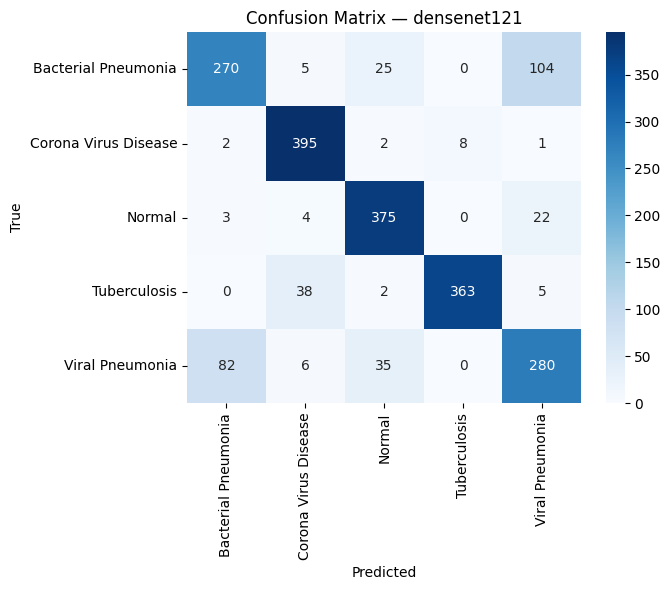


===== Classification Summary (densenet121) =====


,densenet121
accuracy,0.830291
precision_macro,0.830052
precision_weight,0.830521
recall_macro,0.829833
recall_weight,0.830291
f1_macro,0.828250
f1_weight,0.828711
roc_auc_macro,0.965424
roc_auc_weight,0.965568
r2_score,0.113996



===== Per-Class Metrics (densenet121) =====


,class,precision,recall,f1
0,Bacterial Pneumonia,0.756303,0.668317,0.709593
1,Corona Virus Disease,0.881696,0.968137,0.922897
2,Normal,0.854214,0.928218,0.889680
3,Tuberculosis,0.978437,0.889706,0.931964
4,Viral Pneumonia,0.679612,0.694789,0.687117


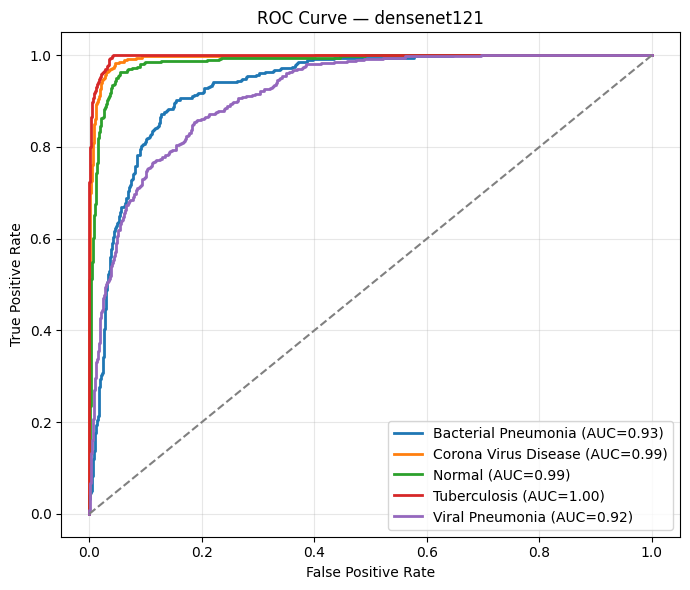

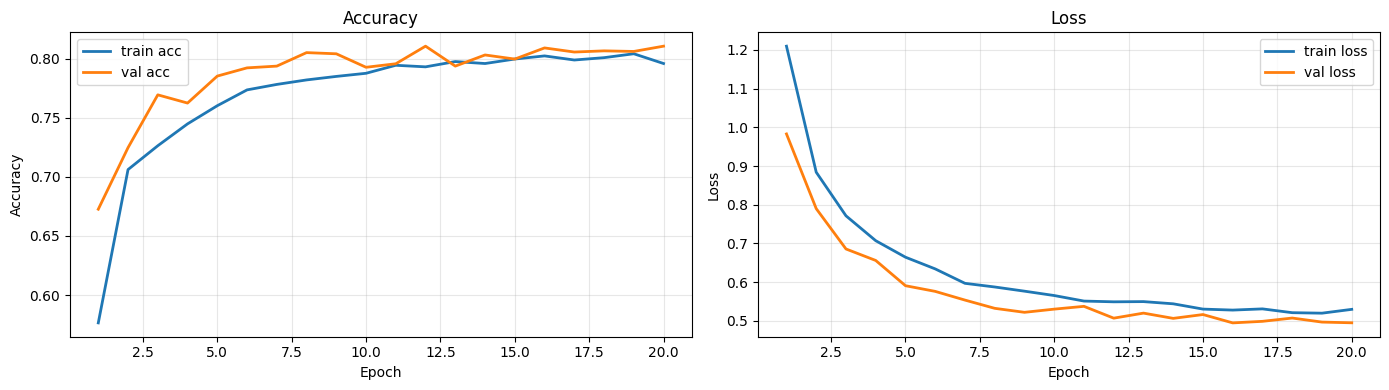

📊 Saved training curves to: results\densenet121_curves.png


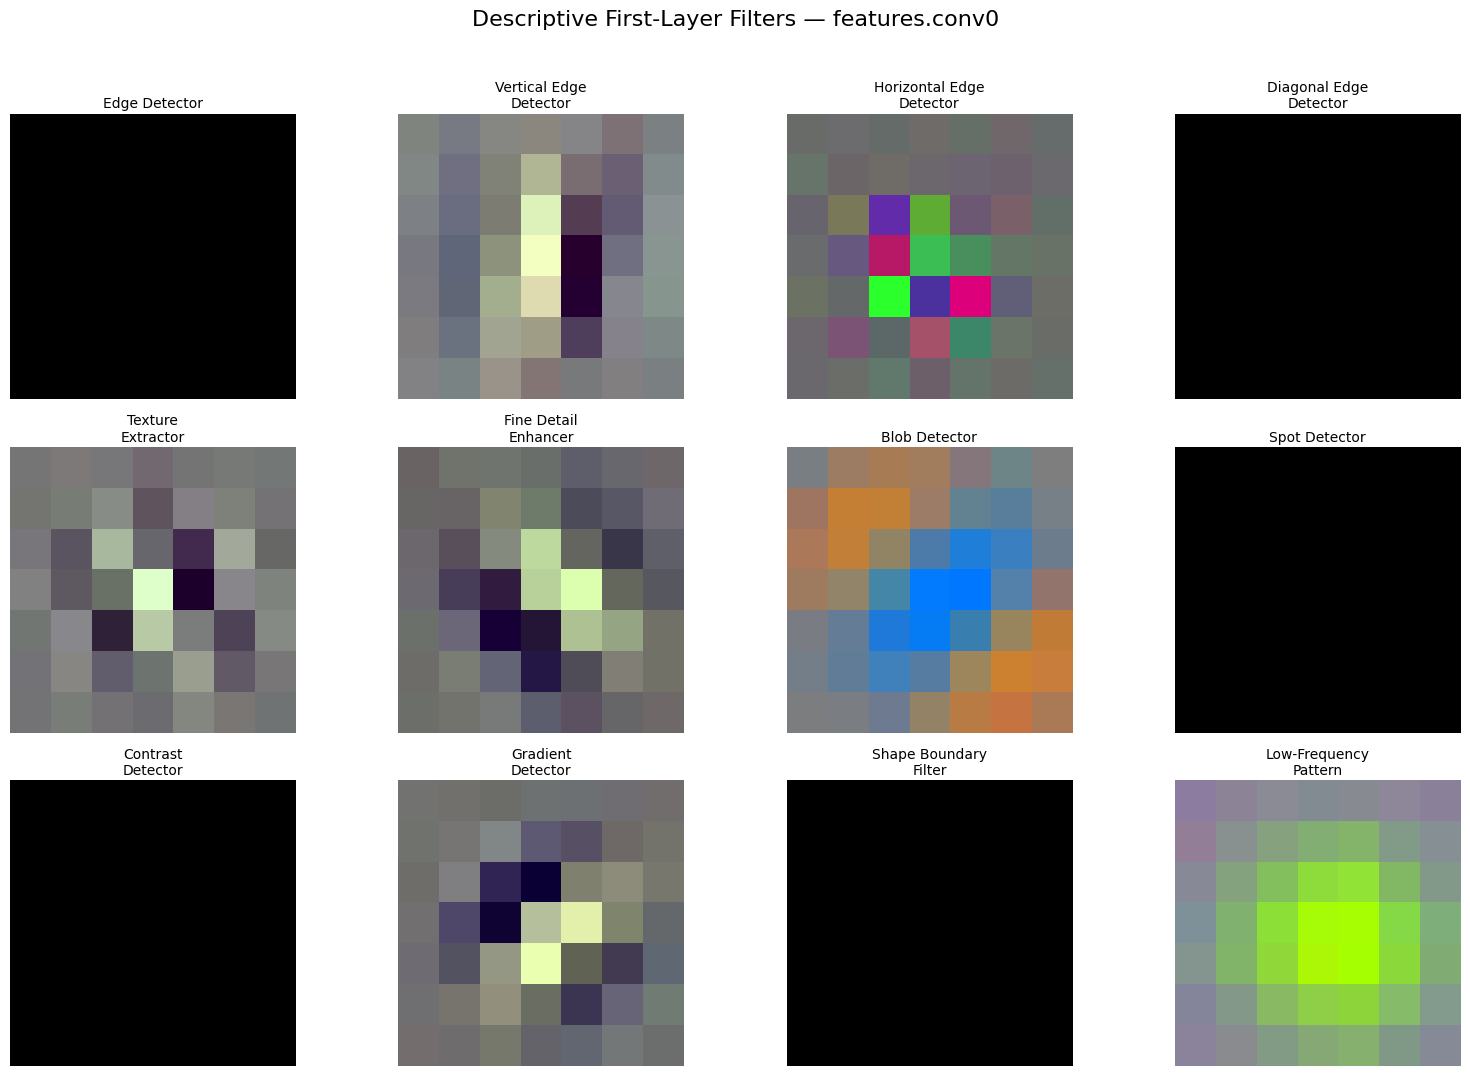

✅ Saved clean filter grid: results\densenet121_descriptive_filters_grid.png


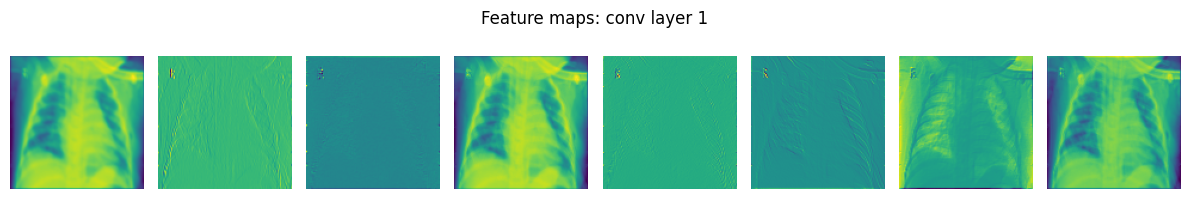


🔍 Showing sample prediction for densenet121


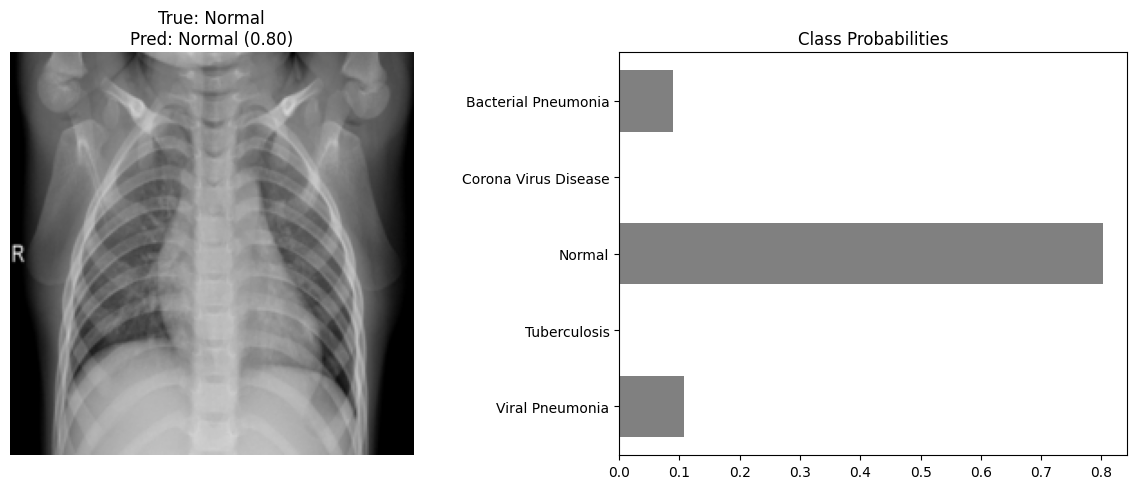


Training model: efficientnet_b0
Head names: ['classifier', 'global_pool', 'conv_head']
=== Frozen training for 10 epochs ===


[efficientnet_b0] Frozen Epoch 1/10: 100%|███████████████████████████████████████████| 379/379 [03:49<00:00,  1.65it/s]


[efficientnet_b0] Frozen Epoch 1: TrainAcc=0.6850, ValAcc=0.7703


[efficientnet_b0] Frozen Epoch 2/10: 100%|███████████████████████████████████████████| 379/379 [02:51<00:00,  2.21it/s]


[efficientnet_b0] Frozen Epoch 2: TrainAcc=0.7859, ValAcc=0.7525


[efficientnet_b0] Frozen Epoch 3/10: 100%|███████████████████████████████████████████| 379/379 [02:21<00:00,  2.67it/s]


[efficientnet_b0] Frozen Epoch 3: TrainAcc=0.8094, ValAcc=0.8031


[efficientnet_b0] Frozen Epoch 4/10: 100%|███████████████████████████████████████████| 379/379 [03:27<00:00,  1.83it/s]


[efficientnet_b0] Frozen Epoch 4: TrainAcc=0.8153, ValAcc=0.8021


[efficientnet_b0] Frozen Epoch 5/10: 100%|███████████████████████████████████████████| 379/379 [02:22<00:00,  2.66it/s]


[efficientnet_b0] Frozen Epoch 5: TrainAcc=0.8180, ValAcc=0.8224


[efficientnet_b0] Frozen Epoch 6/10: 100%|███████████████████████████████████████████| 379/379 [02:18<00:00,  2.73it/s]


[efficientnet_b0] Frozen Epoch 6: TrainAcc=0.8262, ValAcc=0.8180


[efficientnet_b0] Frozen Epoch 7/10: 100%|███████████████████████████████████████████| 379/379 [02:01<00:00,  3.11it/s]


[efficientnet_b0] Frozen Epoch 7: TrainAcc=0.8394, ValAcc=0.8229


[efficientnet_b0] Frozen Epoch 8/10: 100%|███████████████████████████████████████████| 379/379 [03:05<00:00,  2.04it/s]


[efficientnet_b0] Frozen Epoch 8: TrainAcc=0.8418, ValAcc=0.8229


[efficientnet_b0] Frozen Epoch 9/10: 100%|███████████████████████████████████████████| 379/379 [02:16<00:00,  2.77it/s]


[efficientnet_b0] Frozen Epoch 9: TrainAcc=0.8472, ValAcc=0.8214


[efficientnet_b0] Frozen Epoch 10/10: 100%|██████████████████████████████████████████| 379/379 [02:11<00:00,  2.88it/s]


[efficientnet_b0] Frozen Epoch 10: TrainAcc=0.8512, ValAcc=0.8284
=== Fine-tuning for 10 epochs ===


[efficientnet_b0] Fine Epoch 1/10: 100%|█████████████████████████████████████████████| 379/379 [01:59<00:00,  3.16it/s]


[efficientnet_b0] Fine Epoch 1: TrainAcc=0.8566, ValAcc=0.8408, ValLoss=0.4490, LR=2.75e-05
  -> New best, saved


[efficientnet_b0] Fine Epoch 2/10: 100%|█████████████████████████████████████████████| 379/379 [02:18<00:00,  2.73it/s]
E:\AI_and_DS_Softwares\anaconda3\envs\lungs_dl\lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[efficientnet_b0] Fine Epoch 2: TrainAcc=0.8530, ValAcc=0.8383, ValLoss=0.4082, LR=5.00e-05
  -> New best, saved


[efficientnet_b0] Fine Epoch 3/10: 100%|█████████████████████████████████████████████| 379/379 [02:14<00:00,  2.81it/s]


[efficientnet_b0] Fine Epoch 3: TrainAcc=0.8591, ValAcc=0.8229, ValLoss=0.4536, LR=4.81e-05
  -> No improvement (1/5)


[efficientnet_b0] Fine Epoch 4/10: 100%|█████████████████████████████████████████████| 379/379 [02:16<00:00,  2.77it/s]


[efficientnet_b0] Fine Epoch 4: TrainAcc=0.8545, ValAcc=0.8199, ValLoss=0.5839, LR=4.27e-05
  -> No improvement (2/5)


[efficientnet_b0] Fine Epoch 5/10: 100%|█████████████████████████████████████████████| 379/379 [02:14<00:00,  2.83it/s]


[efficientnet_b0] Fine Epoch 5: TrainAcc=0.8573, ValAcc=0.8304, ValLoss=0.4058, LR=3.46e-05
  -> New best, saved


[efficientnet_b0] Fine Epoch 6/10: 100%|█████████████████████████████████████████████| 379/379 [03:11<00:00,  1.98it/s]


[efficientnet_b0] Fine Epoch 6: TrainAcc=0.8545, ValAcc=0.8185, ValLoss=0.4867, LR=2.50e-05
  -> No improvement (1/5)


[efficientnet_b0] Fine Epoch 7/10: 100%|█████████████████████████████████████████████| 379/379 [03:38<00:00,  1.74it/s]


[efficientnet_b0] Fine Epoch 7: TrainAcc=0.8609, ValAcc=0.8289, ValLoss=0.4622, LR=1.54e-05
  -> No improvement (2/5)


[efficientnet_b0] Fine Epoch 8/10: 100%|█████████████████████████████████████████████| 379/379 [02:43<00:00,  2.31it/s]


[efficientnet_b0] Fine Epoch 8: TrainAcc=0.8563, ValAcc=0.8358, ValLoss=0.4239, LR=7.32e-06
  -> No improvement (3/5)


[efficientnet_b0] Fine Epoch 9/10: 100%|█████████████████████████████████████████████| 379/379 [02:44<00:00,  2.30it/s]


[efficientnet_b0] Fine Epoch 9: TrainAcc=0.8608, ValAcc=0.8294, ValLoss=0.9127, LR=1.90e-06
  -> No improvement (4/5)


[efficientnet_b0] Fine Epoch 10/10: 100%|████████████████████████████████████████████| 379/379 [03:57<00:00,  1.59it/s]


[efficientnet_b0] Fine Epoch 10: TrainAcc=0.8588, ValAcc=0.8254, ValLoss=0.4100, LR=0.00e+00
  -> No improvement (5/5)
Early stopping triggered


TTA hflip: 100%|█████████████████████████████████████████████████████████████████████| 127/127 [00:32<00:00,  3.87it/s]



✅ Test Accuracy for efficientnet_b0: 0.8471


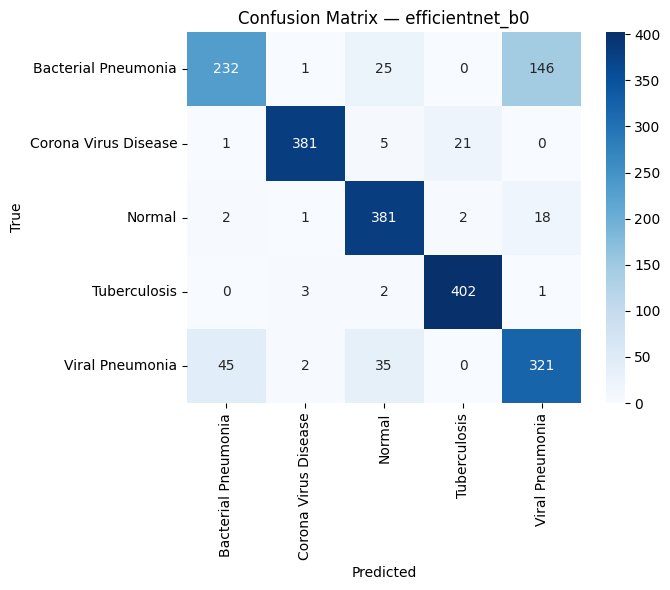


===== Classification Summary (efficientnet_b0) =====


,efficientnet_b0
accuracy,0.847065
precision_macro,0.853471
precision_weight,0.854002
recall_macro,0.846594
recall_weight,0.847065
f1_macro,0.843472
f1_weight,0.843997
roc_auc_macro,0.976496
roc_auc_weight,0.976604
r2_score,0.133778



===== Per-Class Metrics (efficientnet_b0) =====


,class,precision,recall,f1
0,Bacterial Pneumonia,0.828571,0.574257,0.678363
1,Corona Virus Disease,0.981959,0.933824,0.957286
2,Normal,0.850446,0.943069,0.894366
3,Tuberculosis,0.945882,0.985294,0.965186
4,Viral Pneumonia,0.660494,0.796526,0.722160


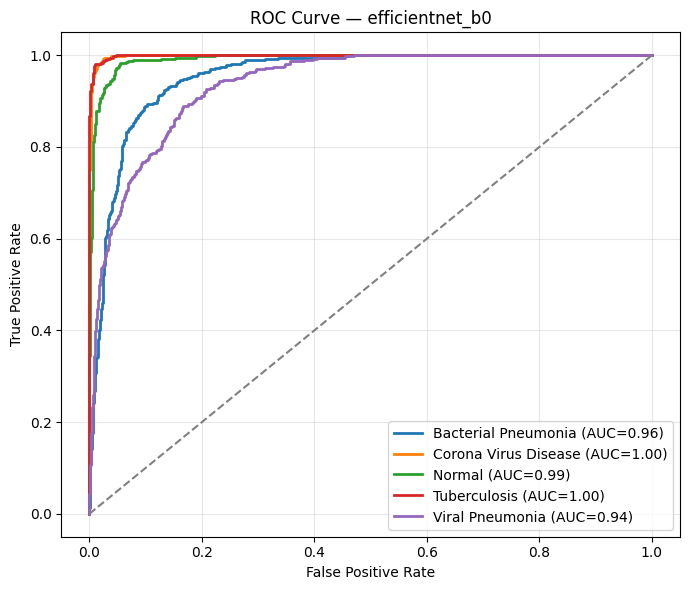

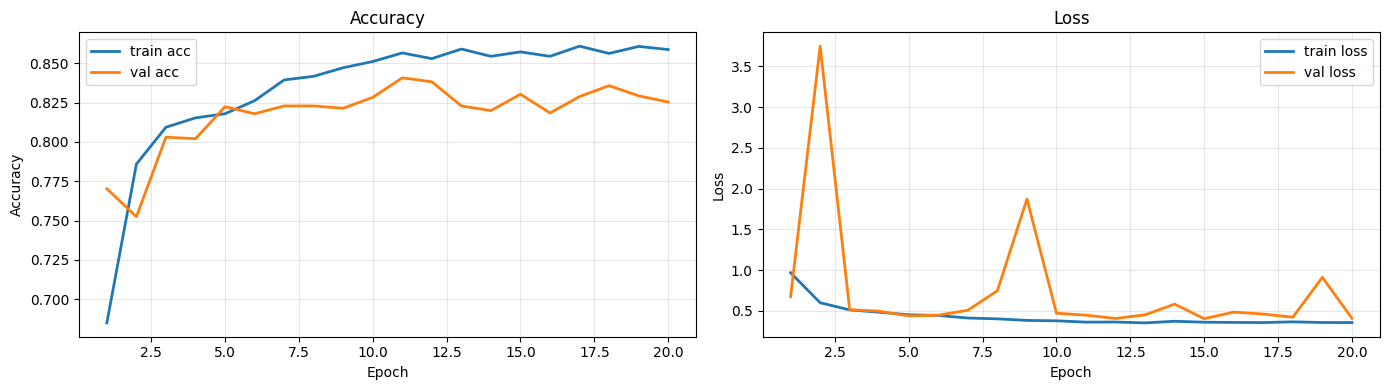

📊 Saved training curves to: results\efficientnet_b0_curves.png


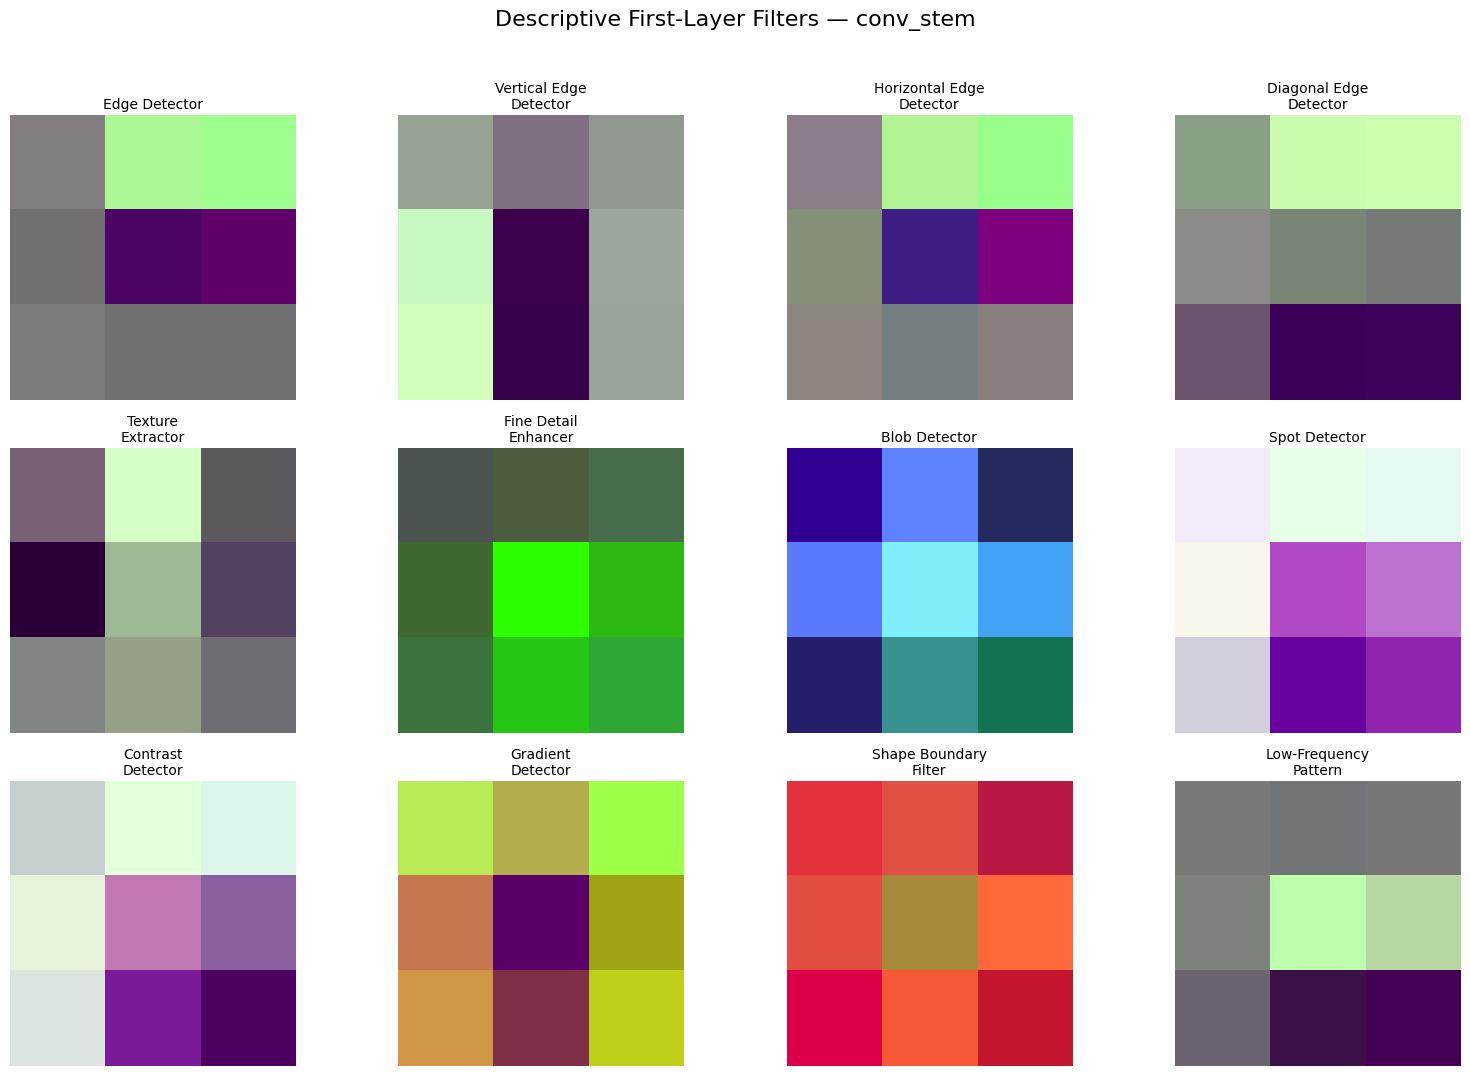

✅ Saved clean filter grid: results\efficientnet_b0_descriptive_filters_grid.png


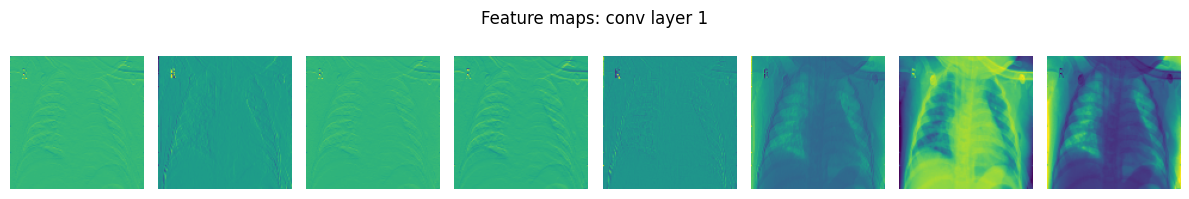


🔍 Showing sample prediction for efficientnet_b0


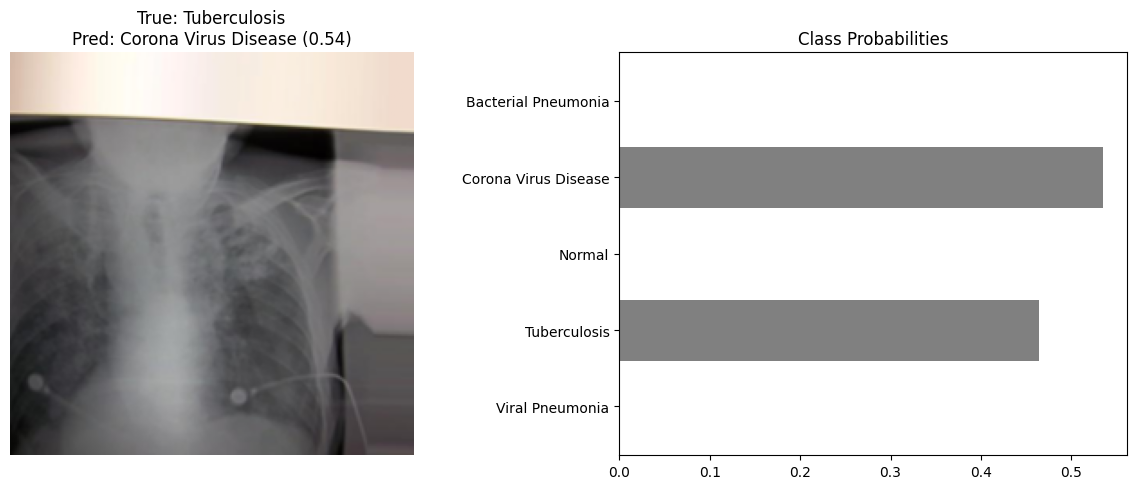


Training model: resnet50
Head names: ['fc', 'global_pool']
=== Frozen training for 10 epochs ===


[resnet50] Frozen Epoch 1/10: 100%|██████████████████████████████████████████████████| 379/379 [03:44<00:00,  1.69it/s]


[resnet50] Frozen Epoch 1: TrainAcc=0.4481, ValAcc=0.6696


[resnet50] Frozen Epoch 2/10: 100%|██████████████████████████████████████████████████| 379/379 [03:08<00:00,  2.01it/s]


[resnet50] Frozen Epoch 2: TrainAcc=0.6686, ValAcc=0.6647


[resnet50] Frozen Epoch 3/10: 100%|██████████████████████████████████████████████████| 379/379 [02:28<00:00,  2.55it/s]


[resnet50] Frozen Epoch 3: TrainAcc=0.6835, ValAcc=0.6687


[resnet50] Frozen Epoch 4/10: 100%|██████████████████████████████████████████████████| 379/379 [02:25<00:00,  2.60it/s]


[resnet50] Frozen Epoch 4: TrainAcc=0.7030, ValAcc=0.6796


[resnet50] Frozen Epoch 5/10: 100%|██████████████████████████████████████████████████| 379/379 [01:50<00:00,  3.43it/s]


[resnet50] Frozen Epoch 5: TrainAcc=0.7028, ValAcc=0.6582


[resnet50] Frozen Epoch 6/10: 100%|██████████████████████████████████████████████████| 379/379 [01:57<00:00,  3.22it/s]


[resnet50] Frozen Epoch 6: TrainAcc=0.7235, ValAcc=0.7024


[resnet50] Frozen Epoch 7/10: 100%|██████████████████████████████████████████████████| 379/379 [02:03<00:00,  3.06it/s]


[resnet50] Frozen Epoch 7: TrainAcc=0.7129, ValAcc=0.6647


[resnet50] Frozen Epoch 8/10: 100%|██████████████████████████████████████████████████| 379/379 [02:12<00:00,  2.87it/s]


[resnet50] Frozen Epoch 8: TrainAcc=0.7240, ValAcc=0.6885


[resnet50] Frozen Epoch 9/10: 100%|██████████████████████████████████████████████████| 379/379 [02:04<00:00,  3.04it/s]


[resnet50] Frozen Epoch 9: TrainAcc=0.7286, ValAcc=0.7113


[resnet50] Frozen Epoch 10/10: 100%|█████████████████████████████████████████████████| 379/379 [02:23<00:00,  2.63it/s]


[resnet50] Frozen Epoch 10: TrainAcc=0.7344, ValAcc=0.7183
=== Fine-tuning for 10 epochs ===


[resnet50] Fine Epoch 1/10: 100%|████████████████████████████████████████████████████| 379/379 [01:56<00:00,  3.25it/s]


[resnet50] Fine Epoch 1: TrainAcc=0.7266, ValAcc=0.7029, ValLoss=0.9029, LR=2.75e-05
  -> New best, saved


[resnet50] Fine Epoch 2/10: 100%|████████████████████████████████████████████████████| 379/379 [01:55<00:00,  3.28it/s]
E:\AI_and_DS_Softwares\anaconda3\envs\lungs_dl\lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[resnet50] Fine Epoch 2: TrainAcc=0.7319, ValAcc=0.6935, ValLoss=0.9043, LR=5.00e-05
  -> No improvement (1/5)


[resnet50] Fine Epoch 3/10: 100%|████████████████████████████████████████████████████| 379/379 [02:57<00:00,  2.14it/s]


[resnet50] Fine Epoch 3: TrainAcc=0.7382, ValAcc=0.7232, ValLoss=0.8465, LR=4.81e-05
  -> New best, saved


[resnet50] Fine Epoch 4/10: 100%|████████████████████████████████████████████████████| 379/379 [03:31<00:00,  1.79it/s]


[resnet50] Fine Epoch 4: TrainAcc=0.7392, ValAcc=0.7034, ValLoss=nan, LR=4.27e-05
  -> No improvement (1/5)


[resnet50] Fine Epoch 5/10: 100%|████████████████████████████████████████████████████| 379/379 [02:13<00:00,  2.83it/s]


[resnet50] Fine Epoch 5: TrainAcc=0.7426, ValAcc=0.7173, ValLoss=nan, LR=3.46e-05
  -> No improvement (2/5)


[resnet50] Fine Epoch 6/10: 100%|████████████████████████████████████████████████████| 379/379 [03:14<00:00,  1.95it/s]


[resnet50] Fine Epoch 6: TrainAcc=0.7418, ValAcc=0.7188, ValLoss=nan, LR=2.50e-05
  -> No improvement (3/5)


[resnet50] Fine Epoch 7/10: 100%|████████████████████████████████████████████████████| 379/379 [02:29<00:00,  2.54it/s]


[resnet50] Fine Epoch 7: TrainAcc=0.7440, ValAcc=0.7227, ValLoss=nan, LR=1.54e-05
  -> No improvement (4/5)


[resnet50] Fine Epoch 8/10: 100%|████████████████████████████████████████████████████| 379/379 [02:01<00:00,  3.13it/s]


[resnet50] Fine Epoch 8: TrainAcc=0.7450, ValAcc=0.7197, ValLoss=nan, LR=7.32e-06
  -> No improvement (5/5)
Early stopping triggered


TTA hflip: 100%|█████████████████████████████████████████████████████████████████████| 127/127 [00:34<00:00,  3.69it/s]



✅ Test Accuracy for resnet50: 0.7681


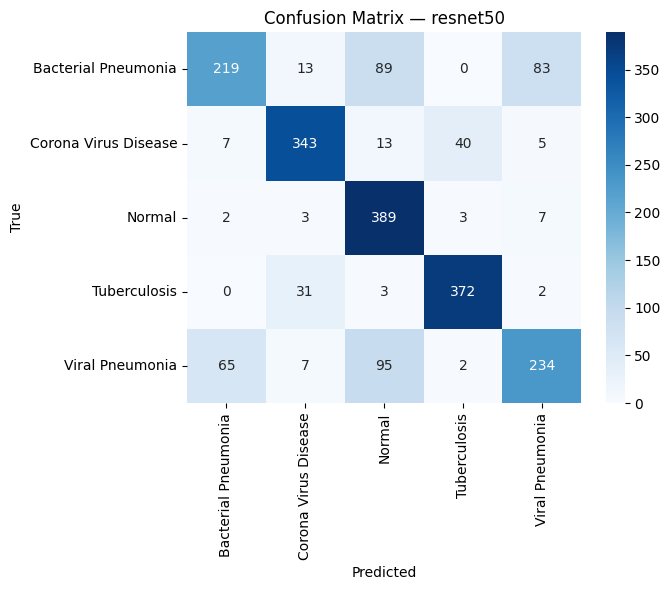


===== Classification Summary (resnet50) =====


,resnet50
accuracy,0.768130
precision_macro,0.774179
precision_weight,0.774622
recall_macro,0.767609
recall_weight,0.768130
f1_macro,0.760697
f1_weight,0.761217
roc_auc_macro,0.948985
roc_auc_weight,0.949146
r2_score,0.115232



===== Per-Class Metrics (resnet50) =====


,class,precision,recall,f1
0,Bacterial Pneumonia,0.747440,0.542079,0.628407
1,Corona Virus Disease,0.863980,0.840686,0.852174
2,Normal,0.660441,0.962871,0.783484
3,Tuberculosis,0.892086,0.911765,0.901818
4,Viral Pneumonia,0.706949,0.580645,0.637602


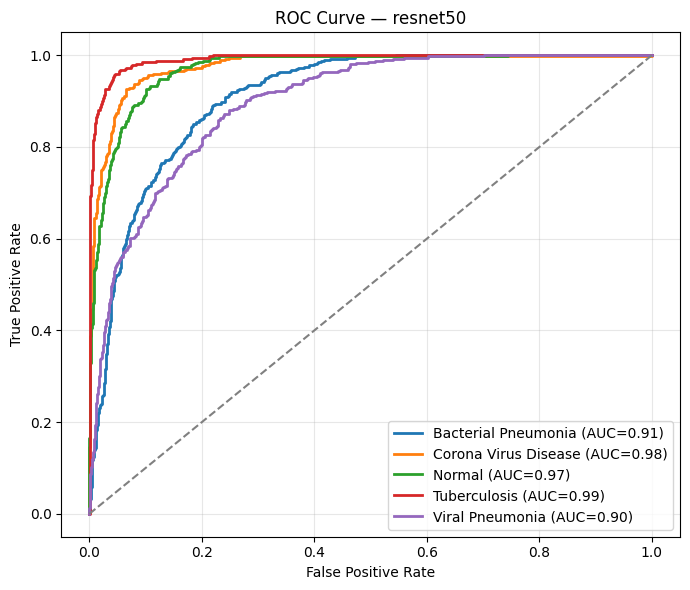

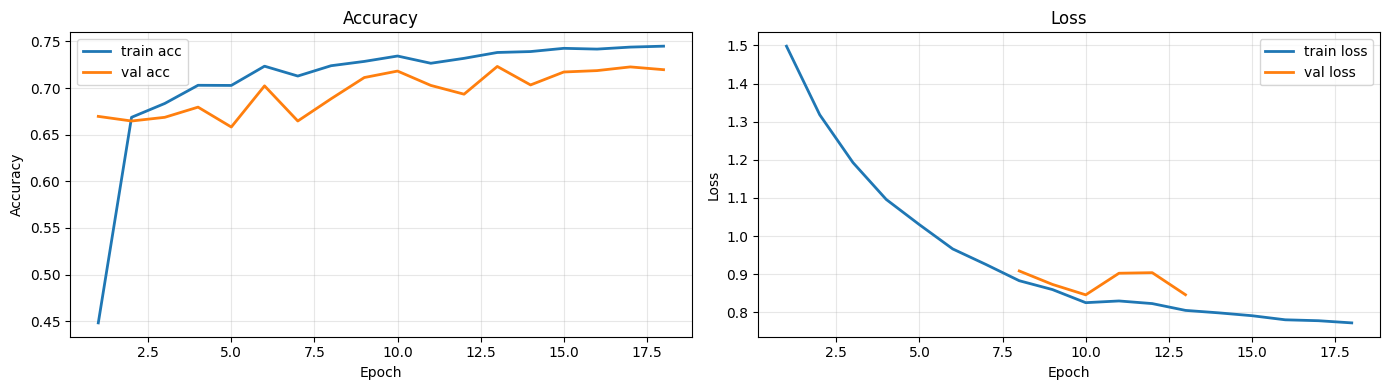

📊 Saved training curves to: results\resnet50_curves.png


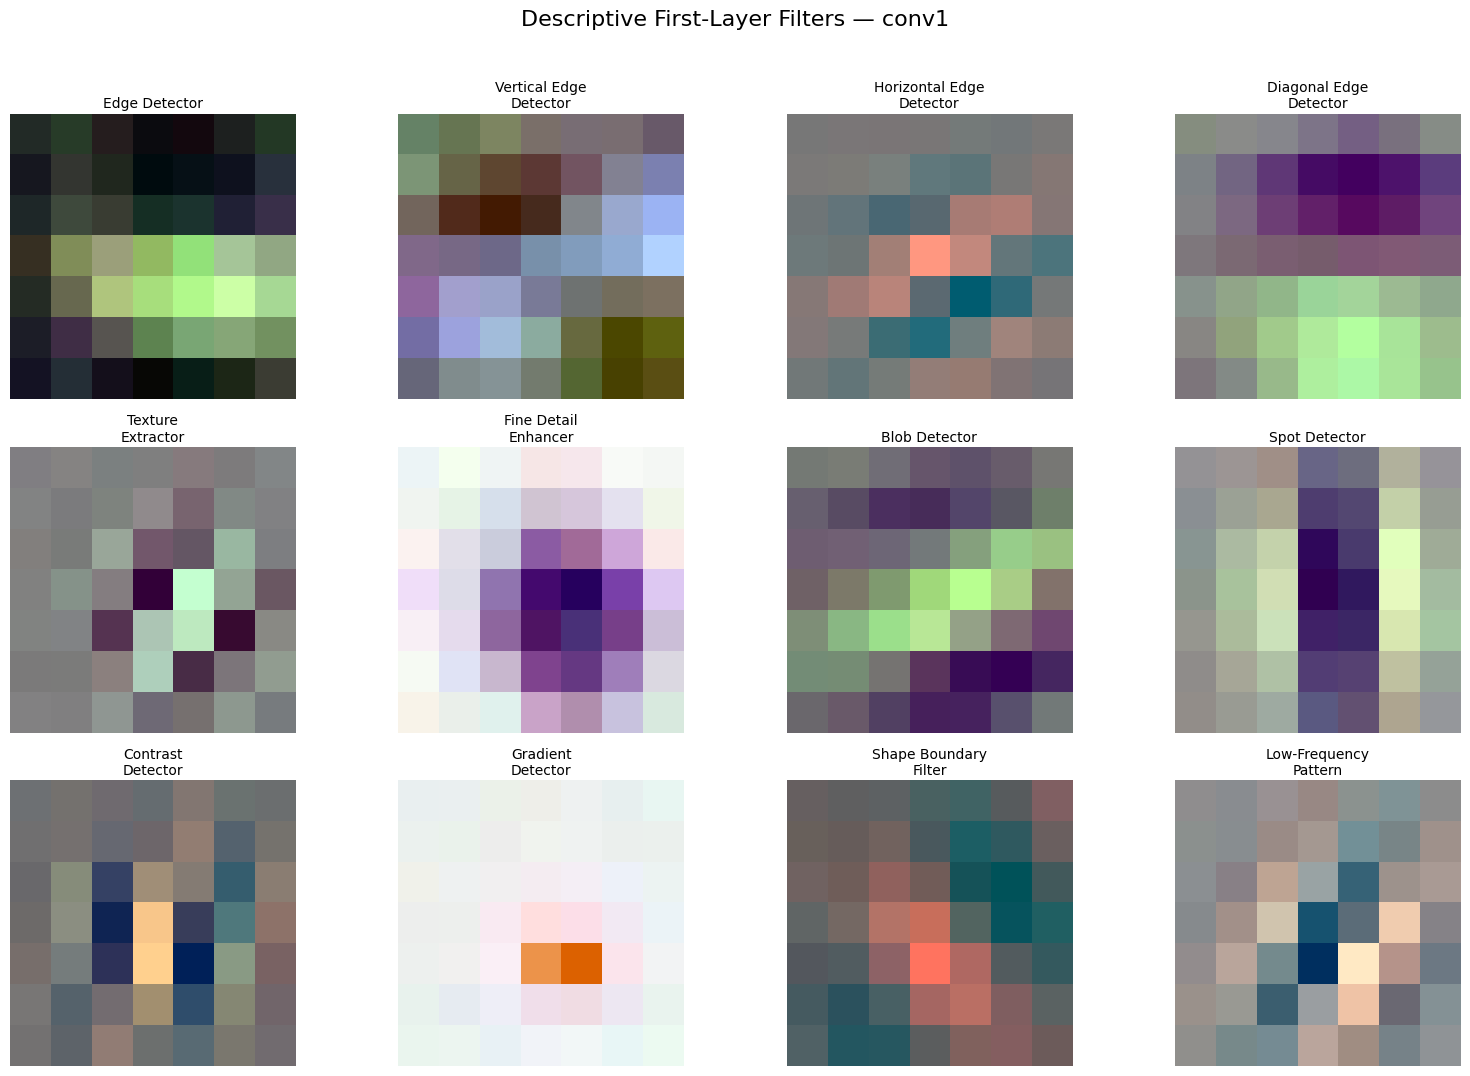

✅ Saved clean filter grid: results\resnet50_descriptive_filters_grid.png


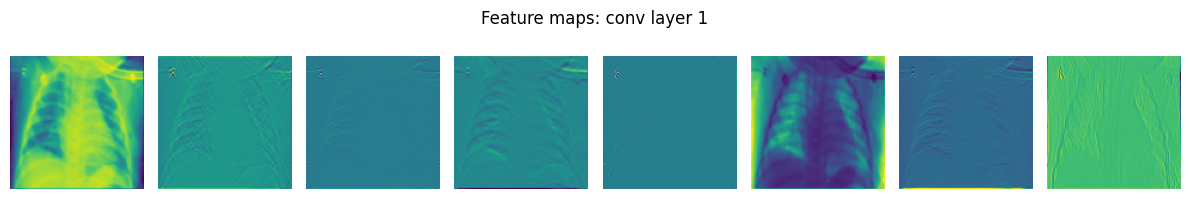


🔍 Showing sample prediction for resnet50


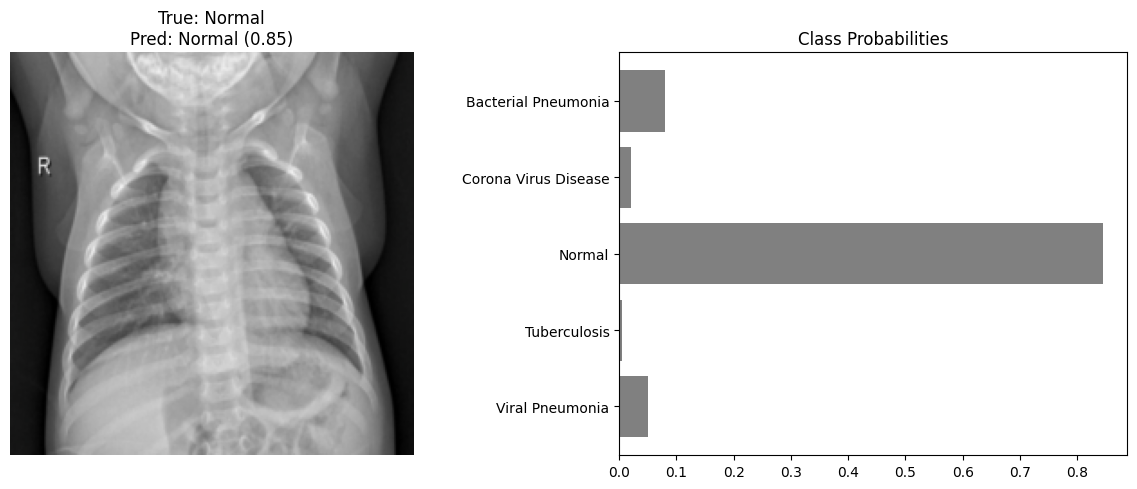

In [6]:
# ============================================
# CELL 6 — MAIN: train models, evaluate, visualize, ensemble
# ============================================

trained_models = {}
results = []    # will include per-model accuracies
ensemble_acc = None

for model_name in config["model_choices"]:
    print("\n" + "="*80)
    print("Training model:", model_name)

    # Build model
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    model.to(device, dtype=torch.float32)
    model = replace_classifier(model, num_classes)

    # Train
    model, history, best_val_acc = train_and_evaluate(
        model,
        train_loader, val_loader,
        config["epochs_frozen"], config["epochs_finetune"],
        config["lr_frozen"], config["lr_finetune"], config["warmup_epochs"],
        config["gradual_unfreeze_k"], config["optimizer"],
        config["dropout_rate"], config["weight_decay"], config["use_amp"],
        config["early_stop_patience"], config["early_stop_metric"], config["early_stop_target_acc"],
        model_name,
        resume_ckpt_path=None
    )

    # =============================
    # Evaluation (with TTA)
    # =============================
    if config["tta"]:
        probs, y_true = tta_predict_optimized(
            model,
            TEST_DIR,
            tta_list=config["tta_transforms"],
            batch_size=config["batch_size"],
            num_workers=0       # Windows-safe (no lambda pickling)
        )
        y_pred = np.argmax(probs, axis=1)

    else:  # Standard prediction
        model.eval()
        y_true = []
        y_pred = []
        all_probs = []
        with torch.no_grad():
            for imgs, labels in tqdm(test_loader, desc=f"Test {model_name}"):
                imgs = imgs.to(device)
                outputs = model(imgs)
                prob_b = torch.softmax(outputs, dim=1).cpu().numpy()
                preds = outputs.argmax(dim=1).cpu().numpy()
                y_true.extend(labels.numpy())
                y_pred.extend(preds)
                all_probs.append(prob_b)

        probs = np.vstack(all_probs)

    # =============================
    # Accuracy
    # =============================
    acc = np.mean(np.array(y_pred) == np.array(y_true))
    print(f"\n✅ Test Accuracy for {model_name}: {acc:.4f}")

    trained_models[model_name] = model
    results.append([model_name, acc, sum(p.numel() for p in model.parameters())/1e6])

    # =============================
    # Confusion Matrix
    # =============================
    plot_and_save_confusion_matrix(y_true, y_pred, class_names, model_name)

    # =============================
    # Classification Summary (F1, Precision, Recall, ROC)
    # =============================
    classification_summary(
        y_true=np.array(y_true),
        y_pred=np.array(y_pred),
        probs=probs,
        class_names=class_names,
        model_name=model_name
    )

    # Plot ROC curves for this model
    plot_roc_curves_per_model(
    y_true=np.array(y_true),
    probs=probs,
    class_names=class_names,
    model_name=model_name
    )


    # =============================
    # Training Curves
    # =============================
    plot_training_curves(history, model_name)

    # =============================
    # First-layer filter visualization
    # =============================
    visualize_first_layer_filters_descriptive(model, max_k=12, save_prefix=model_name)


    # =============================
    # Feature maps visualisation (layer 1)
    # =============================
    try:
        sample_img, _ = test_ds[0]
        if isinstance(sample_img, torch.Tensor):
            s = sample_img.cpu().numpy().transpose(1, 2, 0)
            s = (s * std) + mean
            sample_tensor = torch.tensor(s).permute(2, 0, 1).float()
        else:
            sample_tensor = val_tfms(
                Image.fromarray(np.array(sample_img))
            )
        visualize_feature_maps(model, sample_tensor, layers_to_show=1, save_prefix=model_name)
    except Exception as e:
        print("Feature map visualization skipped:", e)

    # =============================
    # Single-sample Test Prediction
    # =============================
    print(f"\n🔍 Showing sample prediction for {model_name}")
    show_single_test_prediction(model, test_ds)



🤝 Ensembling top-2 models: ['efficientnet_b0', 'densenet121']


Ensemble densenet121: 100%|██████████████████████████████████████████████████████████| 127/127 [00:34<00:00,  3.70it/s]



🎯 Ensemble Top-2 Accuracy: 0.8540


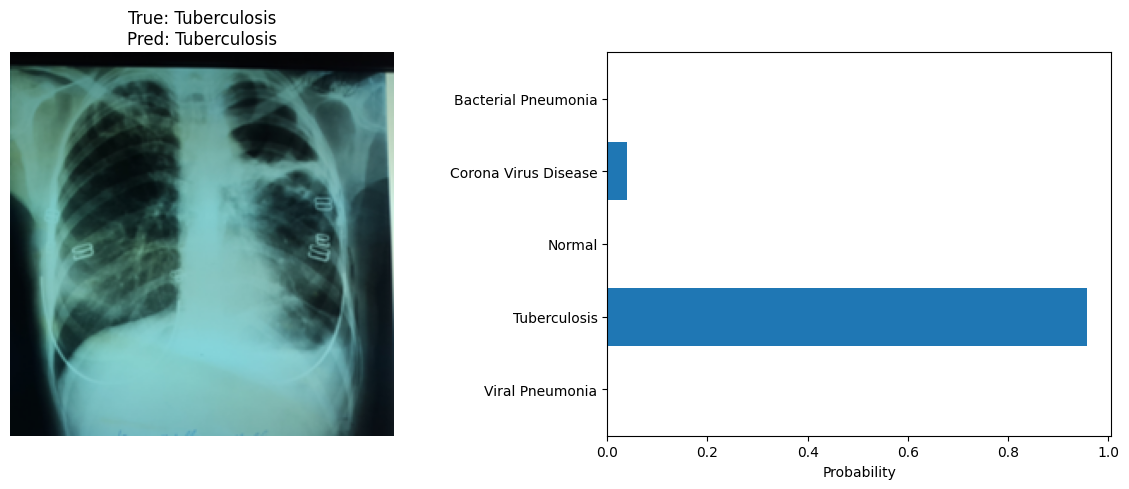

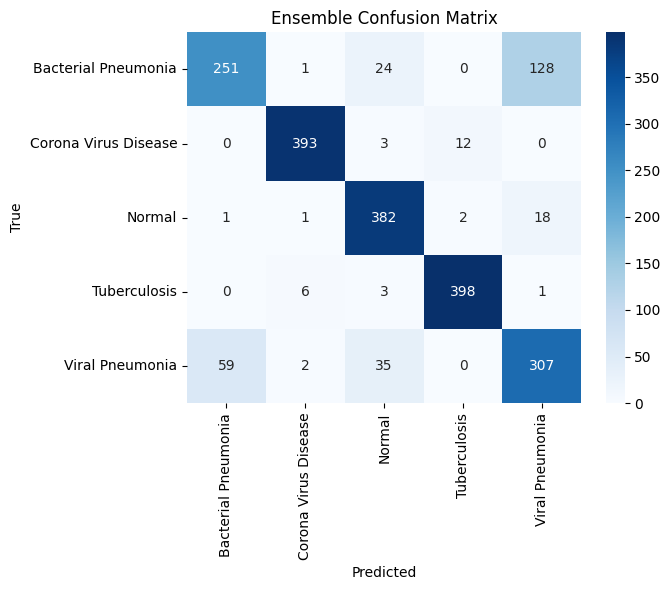


📊 ENSEMBLE CLASSIFICATION SUMMARY

✔ Accuracy: 0.8540

                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.81      0.62      0.70       404
Corona Virus Disease       0.98      0.96      0.97       408
              Normal       0.85      0.95      0.90       404
        Tuberculosis       0.97      0.98      0.97       408
     Viral Pneumonia       0.68      0.76      0.72       403

            accuracy                           0.85      2027
           macro avg       0.86      0.85      0.85      2027
        weighted avg       0.86      0.85      0.85      2027



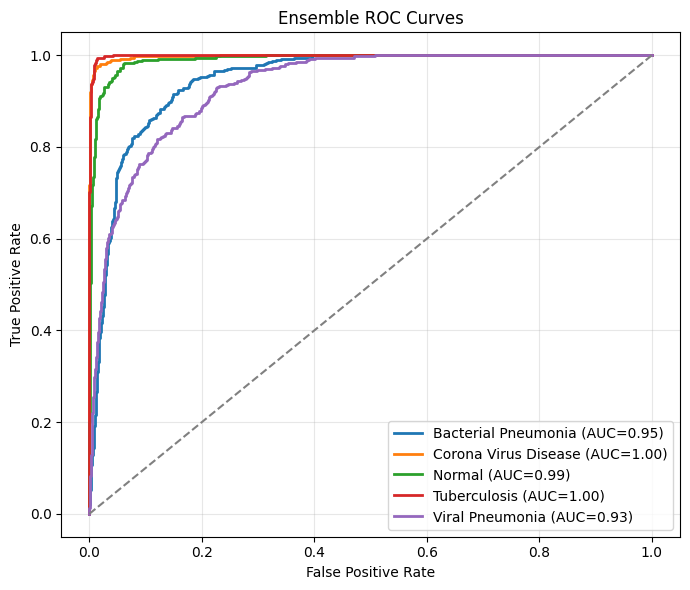

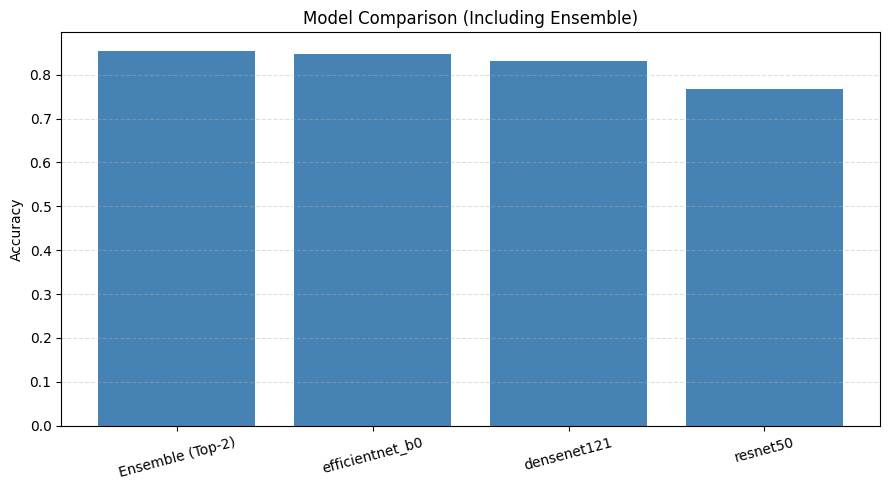


Final Results Table:
              Model  Test Accuracy  Params (M)
3  Ensemble (Top-2)       0.853971    0.000000
1   efficientnet_b0       0.847065    4.013953
0       densenet121       0.830291    6.958981
2          resnet50       0.768130   23.518277


In [7]:
# ============================================================
# ENSEMBLE HELPER FUNCTION 
# ============================================================
def show_ensemble_single_prediction(models, dataset, class_names, index=None):
    """
    Shows a single sample prediction using ensemble-averaged probabilities.
    """
    if index is None:
        index = np.random.randint(0, len(dataset))

    img_tensor, true_label = dataset[index]

    # Unnormalize for display
    inv = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )
    img_vis = inv(img_tensor).numpy().transpose(1,2,0)
    img_vis = np.clip(img_vis, 0, 1)

    # Ensemble probability averaging
    probs_sum = None
    with torch.no_grad():
        for m in models:
            m.eval()
            out = m(img_tensor.unsqueeze(0).to(device))
            soft = torch.softmax(out, dim=1).cpu().numpy()[0]
            probs_sum = soft if probs_sum is None else probs_sum + soft

    probs_avg = probs_sum / len(models)
    pred_class = int(np.argmax(probs_avg))

    # ---- Plot results ----
    fig, ax = plt.subplots(1,2, figsize=(12,5))

    ax[0].imshow(img_vis)
    ax[0].axis("off")
    ax[0].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_class]}")

    ax[1].barh(class_names, probs_avg)
    ax[1].set_xlabel("Probability")
    ax[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

# ============================================================
# ENSEMBLE CLASSIFICATION SUMMARY FUNCTION
# ============================================================
from sklearn.metrics import (
    classification_report, accuracy_score,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

def ensemble_classification_summary(y_true, y_pred, probs, class_names):
    print("\n📊 ENSEMBLE CLASSIFICATION SUMMARY\n")

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"✔ Accuracy: {acc:.4f}\n")

    # Full classification report
    print(classification_report(y_true, y_pred, target_names=class_names))

    # -------------------------------
    # ROC curve for each class
    # -------------------------------
    try:
        y_bin = label_binarize(y_true, classes=list(range(len(class_names))))

        plt.figure(figsize=(7,6))
        for i, cls in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={roc_auc:.2f})")

        plt.plot([0,1], [0,1], "--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Ensemble ROC Curves")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / "ensemble_roc.png", dpi=300)
        plt.show()

    except Exception as e:
        print("ROC Error:", e)

# ============================================================
# ENSEMBLE — Soft-average Top 2 Models
# ============================================================

# -------------------------------------------------------------
# 1️⃣ Determine Top-2 BEFORE modifying results
# -------------------------------------------------------------
results_df_temp = pd.DataFrame(
    results,
    columns=["Model","Test Accuracy","Params (M)"]
)

# remove previous ensemble entries
results_df_temp = results_df_temp[~results_df_temp["Model"].str.contains("Ensemble")]

results_df_temp = results_df_temp.sort_values("Test Accuracy", ascending=False)

if len(results_df_temp) < 2:
    print("⚠️ Not enough models to ensemble.")
    top2 = []
else:
    top2 = list(results_df_temp["Model"].iloc[:2])

print("\n🤝 Ensembling top-2 models:", top2)

# -------------------------------------------------------------
# 2️⃣ Compute Ensemble Soft-Average Probabilities
# -------------------------------------------------------------
probs_list = []

for mname in top2:
    m = trained_models[mname]
    m.eval()

    p_all = []
    with torch.no_grad():
        for imgs, _ in tqdm(test_loader, desc=f"Ensemble {mname}"):
            imgs = imgs.to(device)
            out = m(imgs)
            p_all.append(torch.softmax(out, dim=1).cpu().numpy())

    probs_list.append(np.vstack(p_all))

avg_probs = np.mean(np.stack(probs_list, axis=0), axis=0)
ensemble_preds = np.argmax(avg_probs, axis=1)
y_true_array = np.array([y for _, y in test_ds.samples])

ensemble_acc = (ensemble_preds == y_true_array).mean()
print(f"\n🎯 Ensemble Top-2 Accuracy: {ensemble_acc:.4f}")

# -------------------------------------------------------------
# 3️⃣ Add ensemble results only once
# -------------------------------------------------------------
results.append(["Ensemble (Top-2)", ensemble_acc, 0])

# -------------------------------------------------------------
# 4️⃣ Display sample ensemble prediction
# -------------------------------------------------------------
show_ensemble_single_prediction(
    models=[trained_models[m] for m in top2],
    dataset=test_ds,
    class_names=class_names
)

# -------------------------------------------------------------
# 5️⃣ Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(y_true_array, ensemble_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "ensemble_confusion_matrix.png", dpi=300)
plt.show()

# -------------------------------------------------------------
# 6️⃣ Classification Summary + ROC Curves
# -------------------------------------------------------------
ensemble_classification_summary(y_true_array, ensemble_preds, avg_probs, class_names)

# -------------------------------------------------------------
# 7️⃣ Final accuracy bar graph
# -------------------------------------------------------------
results_df = pd.DataFrame(results, columns=["Model","Test Accuracy","Params (M)"])
results_df_sorted = results_df.sort_values("Test Accuracy", ascending=False)

plt.figure(figsize=(9,5))
plt.bar(results_df_sorted["Model"], results_df_sorted["Test Accuracy"], color="steelblue")
plt.ylabel("Accuracy")
plt.title("Model Comparison (Including Ensemble)")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "model_accuracy_comparison_with_ensemble.png", dpi=300)
plt.show()

print("\nFinal Results Table:")
print(results_df_sorted)


In [15]:
import torch
import timm
from pathlib import Path

RESULTS_DIR = Path("results")       # adjust if needed
OUT_DIR = Path("models_out")
OUT_DIR.mkdir(exist_ok=True)

model_choices = ["densenet121", "efficientnet_b0", "resnet50"]
NUM_CLASSES = 5   # your project uses 5 classes

for backbone in model_choices:
    print(f"\n=== Processing {backbone} ===")

    best_path = RESULTS_DIR / f"best_{backbone}.pth"
    if not best_path.exists():
        print(f"❌ Missing: {best_path}")
        continue

    print("📥 Loading checkpoint:", best_path)
    ckpt = torch.load(best_path, map_location="cpu")

    # Rebuild architecture
    model = timm.create_model(backbone, pretrained=False, num_classes=NUM_CLASSES)

    # Handle raw state_dict vs dict with nesting
    if isinstance(ckpt, dict) and "model_state" in ckpt:
        state_dict = ckpt["model_state"]
    else:
        state_dict = ckpt

    # Load weights
    model.load_state_dict(state_dict)
    print("✔ Loaded successfully")

    # Save clean state_dict for Streamlit
    out_path = OUT_DIR / f"{backbone}.pth"
    torch.save(model.state_dict(), out_path)
    print("✔ Saved clean model →", out_path)



=== Processing densenet121 ===
📥 Loading checkpoint: results\best_densenet121.pth
✔ Loaded successfully
✔ Saved clean model → models_out\densenet121.pth

=== Processing efficientnet_b0 ===
📥 Loading checkpoint: results\best_efficientnet_b0.pth
✔ Loaded successfully
✔ Saved clean model → models_out\efficientnet_b0.pth

=== Processing resnet50 ===
📥 Loading checkpoint: results\best_resnet50.pth
✔ Loaded successfully
✔ Saved clean model → models_out\resnet50.pth
